# Hotel booking prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # train processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

#Visualization tools
from math import pi
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#SKLearn
from sklearn.model_selection import train_test_split
# Input train files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iso3166-country-code-pair/country-code.csv
/kaggle/input/hotelbookingdemandwl/pipeline.png
/kaggle/input/hotel-booking-demand/hotel_bookings.csv


# Introduction

In the present day, booking for a nice, beautiful accommodation are just a click away. We can browse through online travel booking platforms, search and made a booking within a minute. This benefit not only for traveller like us, but also for hotel operator around the globe. 

While hotel operator around the globe are enjoying benefit from online travel booking platforms to boost their occupancy rate. There are also some unavoidable drawbacks, some of them may include higher cancellation rate when online travel booking platforms offer book now pay later promotion. 

Therefore, in order to maximize revenue per room and minimize loss due to cancellation, hotel operator should be able to predict whether a given reservation are likely to canceled or not? With this information, hotel operator might be able to implement overbooking policy to compensate for canceled booking. Moreover, they can utilize this information to manage their workforce more effectively

In [2]:
m = folium.Map(location=[38.566, -8.047], zoom_start=7)
#add marker of Lisbon city
folium.Marker(
    [38.733, -9.143],
    popup='Lisbon (City Hotel)'
).add_to(m)
#add marker of Algarve
folium.Marker(
    [37.0180, -7.9308],
    popup='Algarve (Resort hotel)'
).add_to(m)
m


## Problem statement

This could be viewed as supervised binary classification problem. With given booking information : number of guests, number of special requirement, agencies and etc., we will try to predict whether a reservation will be confirmed or canceled.
With different baseline classification algorithms (such as Logistic Regression, Random Forest, Gradient-Boosting, Ada-Boost and Support Vector Machine), we’ll evaluate them with default scikit-learn configuration and continue to develop most suitable algorithm.

Durin Exploratory Data Analysis I'll try to answer . . .
1. Prediction of reservation cancellation likelihood
1. Does lead time has relation with cancellation?
1. Which agencies has high rate of cancellation? (rank from top 10 most used agencies)
1. What month are likely to be cancelled? 
1. Which countries are likely to cancel reservation? (rank my top 20 countries)
1. If reserved room and assigned room are not the same ? are there any possibility of cancellation?
1. Deposit type vs cancellation? (+ lead time?)
1. Customer type vs cancellation?
1. Occupancy of city hotel vs resort hotel over the year
1. Which market segment has high rate of cancellation?
1. Which distribution channel has high rate of cancellation?
1. Number of family member vs cancellation?
1. When the best time of year to book a hotel room is? 
1. The optimal length of stay in order to get the best daily rate? 


# Data Exploration

This data set were extracted from hotels’ Property Management System (PMS) SQL databases which contains booking information for **a city hotel located in the city of Lisbon** and **a resort hotel at the resort region of Algarve**. Both hotels are located in Portugal, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.




All personally identifying information has been removed from the data.

### Data Dictionary

|variable                       |class     |description |
|:------------------------------|:---------|:-----------|
|hotel                          |character | Hotel (H1 = Resort Hotel or H2 = City Hotel) |
|is_canceled                    |double    | Value indicating if the booking was canceled (1) or not (0) |
|lead_time                      |double    | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
|arrival_date_year              |double    | Year of arrival date|
|arrival_date_month             |character | Month of arrival date|
|arrival_date_week_number       |double    | Week number of year for arrival date|
|arrival_date_day_of_month      |double    | Day of arrival date|
|stays_in_weekend_nights        |double    | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
|stays_in_week_nights           |double    |  Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|adults                         |double    | Number of adults|
|children                       |double    | Number of children|
|babies                         |double    |Number of babies |
|meal                           |character | Type of meal booked. Categories are presented in standard hospitality meal packages: <br> Undefined/SC – no meal package;<br>BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board (breakfast, lunch and dinner) |
|country                        |character | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
|market_segment                 |character | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
|distribution_channel           |character | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
|is_repeated_guest              |double    | Value indicating if the booking name was from a repeated guest (1) or not (0) |
|previous_cancellations         |double    | Number of previous bookings that were cancelled by the customer prior to the current booking |
|previous_bookings_not_canceled |double    | Number of previous bookings not cancelled by the customer prior to the current booking |
|reserved_room_type             |character | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
|assigned_room_type             |character | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons |
|booking_changes                |double    | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type                   |character | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:<br>No Deposit – no deposit was made;<br>Non Refund – a deposit was made in the value of the total stay cost;<br>Refundable – a deposit was made with a value under the total cost of stay. |
|agent                          |character | ID of the travel agency that made the booking |
|company                        |character | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
|days_in_waiting_list           |double    | Number of days the booking was in the waiting list before it was confirmed to the customer |
|customer_type                  |character | Type of booking, assuming one of four categories:<br>Contract - when the booking has an allotment or other type of contract associated to it;<br>Group – when the booking is associated to a group;<br>Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>Transient-party – when the booking is transient, but is associated to at least other transient booking|
|adr                            |double    | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
|required_car_parking_spaces    |double    | Number of car parking spaces required by the customer |
|total_of_special_requests      |double    | Number of special requests made by the customer (e.g. twin bed or high floor)|
|reservation_status             |character | Reservation last status, assuming one of three categories:<br>Canceled – booking was canceled by the customer;<br>Check-Out – customer has checked in but already departed;<br>No-Show – customer did not check-in and did inform the hotel of the reason why |
|reservation_status_date        |double    | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel|


In [3]:
df = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
#Set aside test set and not touch them

X = df.copy().drop(columns = 'is_canceled')
Y = df.copy()['is_canceled']

X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size = 0.04, random_state = 1)

In [5]:
#For sake of Exploratory train Analysis, let's put X_train,y_train together,
train = pd.DataFrame.join(X_train,y_train) #train to be intrepete will be only training set
train.head() 

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_canceled
25220,Resort Hotel,90,2016,June,24,9,2,8,2,0.0,...,243.0,NaN,0,Contract,88.90,0,1,Check-Out,2016-06-19,0
40038,Resort Hotel,191,2017,August,35,31,2,5,2,0.0,...,40.0,NaN,0,Contract,114.80,0,0,Check-Out,2017-09-07,0
109891,City Hotel,161,2017,April,15,11,2,5,2,0.0,...,7.0,NaN,0,Transient,119.39,0,1,Check-Out,2017-04-18,0
5070,Resort Hotel,183,2016,April,16,16,1,1,1,0.0,...,298.0,NaN,0,Transient-Party,54.50,0,0,Check-Out,2016-04-18,0
71606,City Hotel,167,2017,July,28,9,1,0,3,0.0,...,9.0,NaN,0,Transient,107.10,0,1,Canceled,2017-05-10,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114614 entries, 25220 to 98539
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           114614 non-null  object 
 1   lead_time                       114614 non-null  int64  
 2   arrival_date_year               114614 non-null  int64  
 3   arrival_date_month              114614 non-null  object 
 4   arrival_date_week_number        114614 non-null  int64  
 5   arrival_date_day_of_month       114614 non-null  int64  
 6   stays_in_weekend_nights         114614 non-null  int64  
 7   stays_in_week_nights            114614 non-null  int64  
 8   adults                          114614 non-null  int64  
 9   children                        114610 non-null  float64
 10  babies                          114614 non-null  int64  
 11  meal                            114614 non-null  object 
 12  country      

In [7]:
print('Most 5 incompleted features')
train.isnull().sum().sort_values(ascending=False)[:5]

Most 5 incompleted features


company     108103
agent        15622
country        464
children         4
meal             0
dtype: int64

## 'Company' attribute

In [8]:
train['company'].value_counts()

40.0     890
223.0    755
67.0     255
45.0     236
153.0    207
        ... 
442.0      1
132.0      1
229.0      1
76.0       1
305.0      1
Name: company, Length: 348, dtype: int64

**Company** : ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons

for NULL values, It can be intrepete as hotel being booked personally. So in this case, I'll impute "NULL" with 0

## 'Agent' attribute

In [9]:
train['agent'].value_counts()

9.0      30755
240.0    13341
1.0       6910
14.0      3475
7.0       3398
         ...  
416.0        1
54.0         1
446.0        1
432.0        1
397.0        1
Name: agent, Length: 330, dtype: int64

**agent** : ID of the travel agency that made the booking

for NULL values, it mean that hotel has been reserved personally (not via Agency). Again I'll impute "Null" with 0

## 'Country' attribute

In [10]:
train['country'].value_counts().sort_values(ascending=False)

PRT    46658
GBR    11666
FRA    10007
ESP     8186
DEU     6996
       ...  
MRT        1
BDI        1
TGO        1
LCA        1
KIR        1
Name: country, Length: 176, dtype: int64

**country** : Country of origin. Categories are represented in the ISO 3155–3:2013 format. 

For reservation with unspecified country, I'll impute with "UNK" as short for Unknown



## 'Children' attribute

In [11]:
train['children'].value_counts().sort_values(ascending=False)

0.0     106381
1.0       4665
2.0       3490
3.0         73
10.0         1
Name: children, dtype: int64

**children** : Number of children

Most of reservation included no children. So I'll impute missing values with 0.

In [12]:
#Impute missing value with above criteria
Nan_handling = {'company': 0,
                'agent' : 0,
                'country' : 'UNK',
                'children' : 0
               }
train = train.fillna(value = Nan_handling)
train = train.replace({'CN':'CHN'}) #update China ISO naming from CN to CHN

# Exploratory Data Analysis

Where does our guest come from?

In [13]:
output_notebook()

x = train['country'].value_counts()[:20].to_dict()

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'country'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
           tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='country', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None
show(p)

Loading BokehJS ...

In [14]:
import folium
world_geo = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'

plot_map = train.groupby('country').count().reset_index()
plot_map['hotel_%'] = plot_map['hotel']/plot_map['hotel'].sum()*100

m = folium.Map(location=[40.417, 3.704], zoom_start=3)

folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=plot_map,
    columns=['country', 'hotel_%'],
    key_on='feature.id',
    fill_color='YlOrRd',
    bins = 9,
    fill_opcity=0.7,
    line_opacity=0.2,
    legend_name='% of Total Reservation'
).add_to(m)

folium.LayerControl().add_to(m)

m

Top 5 visitors are from nearby European countries. With the largest portion from Portugal, following by UK, France, Spain and Germany respectively

In [15]:
cat_col = train.select_dtypes(include = 'object').columns.tolist()
discrete_num_col = train.select_dtypes(exclude = 'object').columns.tolist()
continuous_num_col = ['lead_time','agent','company','adr','days_in_waiting_list']
for i in range(len(continuous_num_col)):
    discrete_num_col.remove(continuous_num_col[i])

## Univariate Analysis

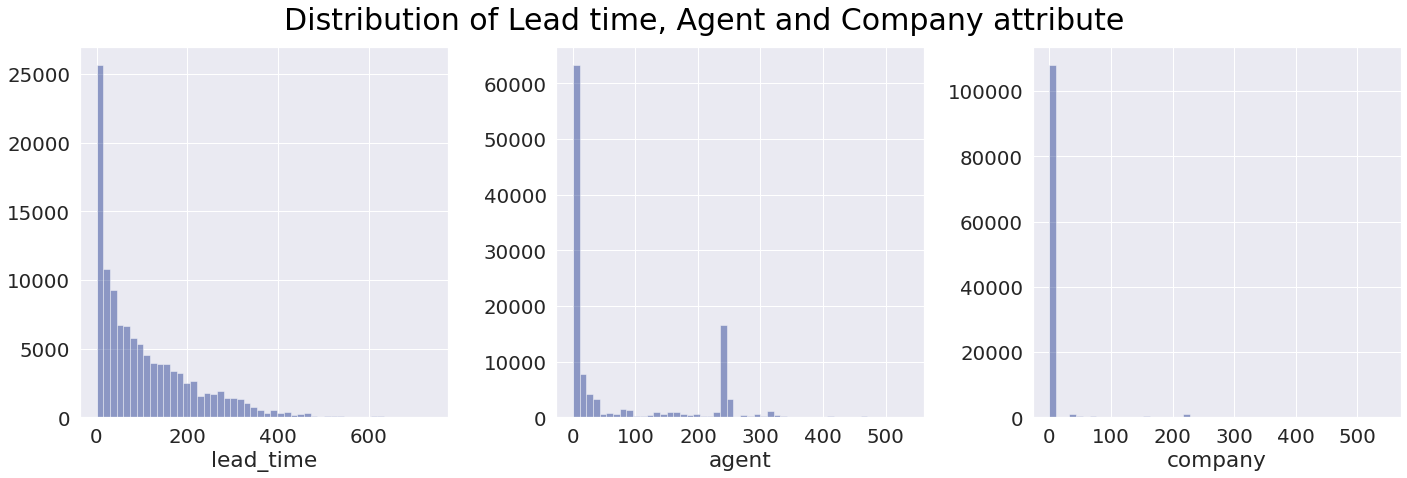

In [16]:
#continuous numerical data
fig = plt.figure(figsize=(20,12))
fig.suptitle('Distribution of Lead time, Agent and Company attribute',size = 30,y=1.02)
sns.set(style='darkgrid',palette = 'dark', font_scale = 1.8)
for index,col in enumerate(continuous_num_col):
    if col in ['lead_time','agent','company']:
        plt.subplot(2,3,index+1)
        sns.distplot(train[col],kde =False,color = 'b')
    else:
        continue
fig.tight_layout()

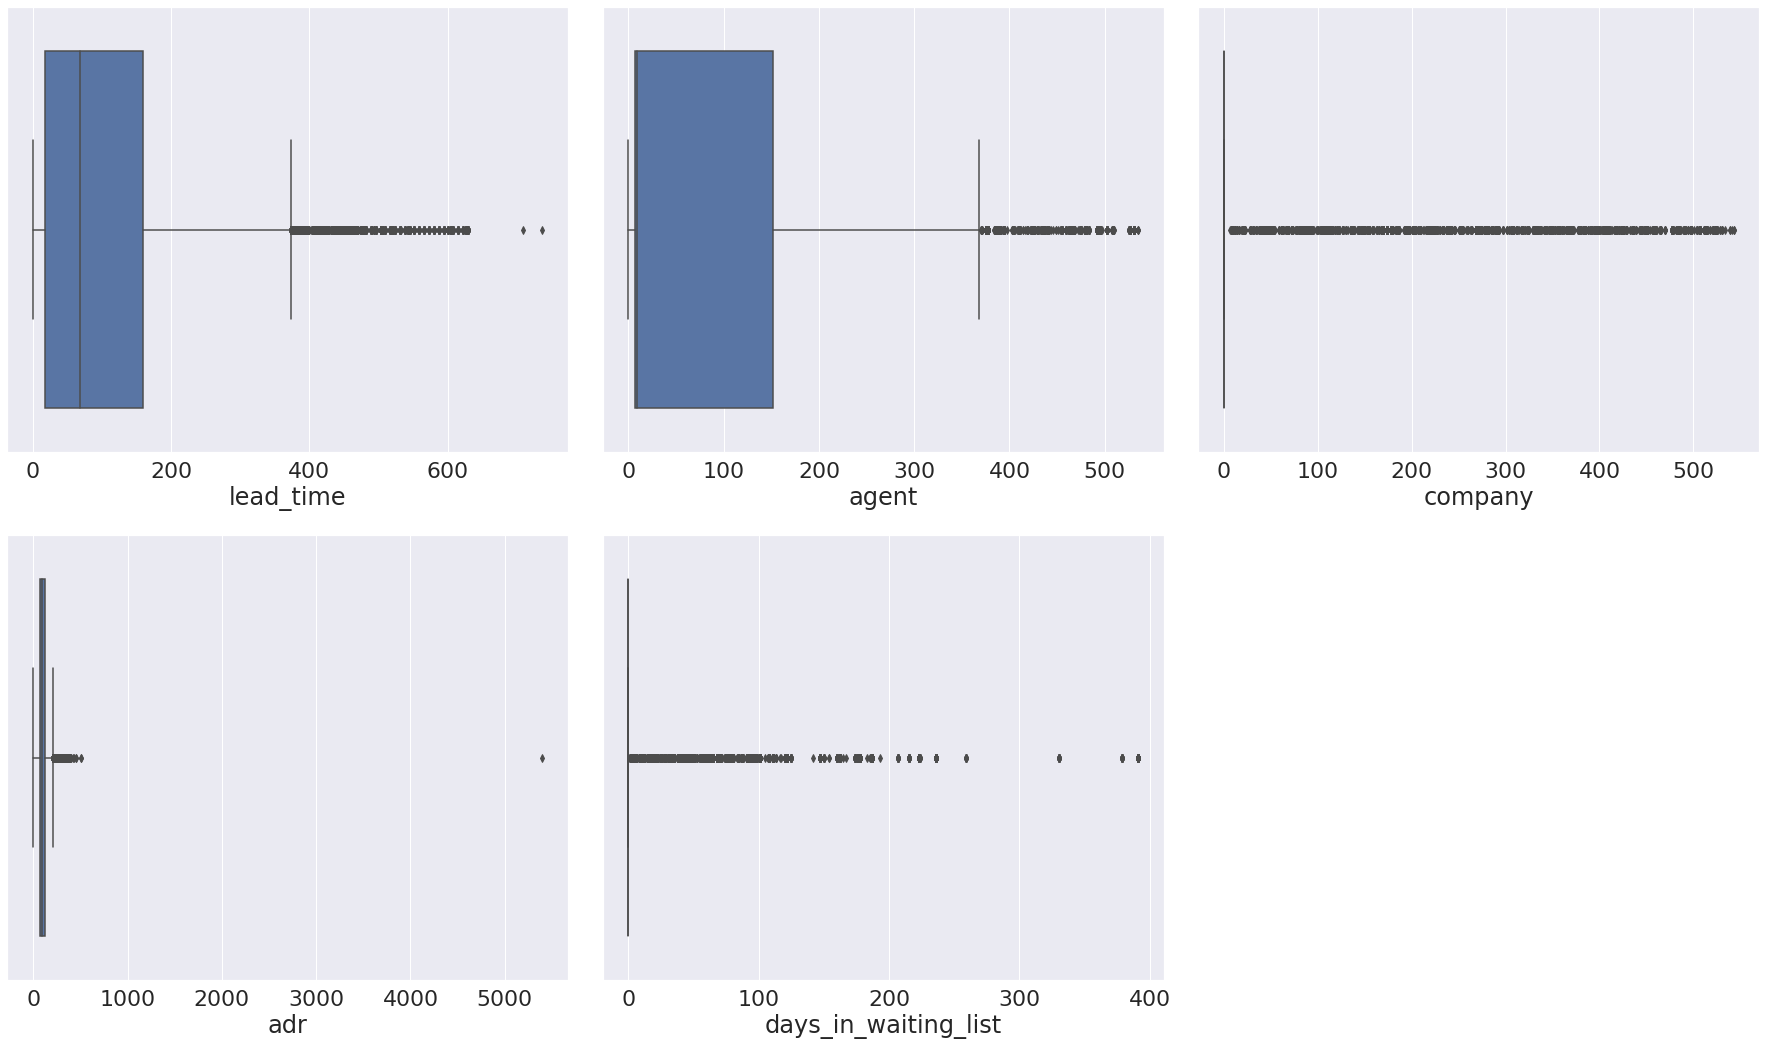

In [17]:
#continuous numerical data
fig = plt.figure(figsize=(25,15))
sns.set_style('darkgrid')
sns.set(font_scale = 2.0)
for index,col in enumerate(continuous_num_col):
    plt.subplot(2,3,index+1)
    sns.boxplot(train[col])
fig.tight_layout(pad=1.0)

Finding : 
1. lead time (days) : Almost all reservations were made with lead times $\leq$ 1 year
1. agent & company : Most of reservations were made personally and there are only major travel agencies which have significant amount compared to number of personally reserved
1. company and days_in_waiting_list : look like they're not much important. Since there is no variation in information (almost all observation show 0)

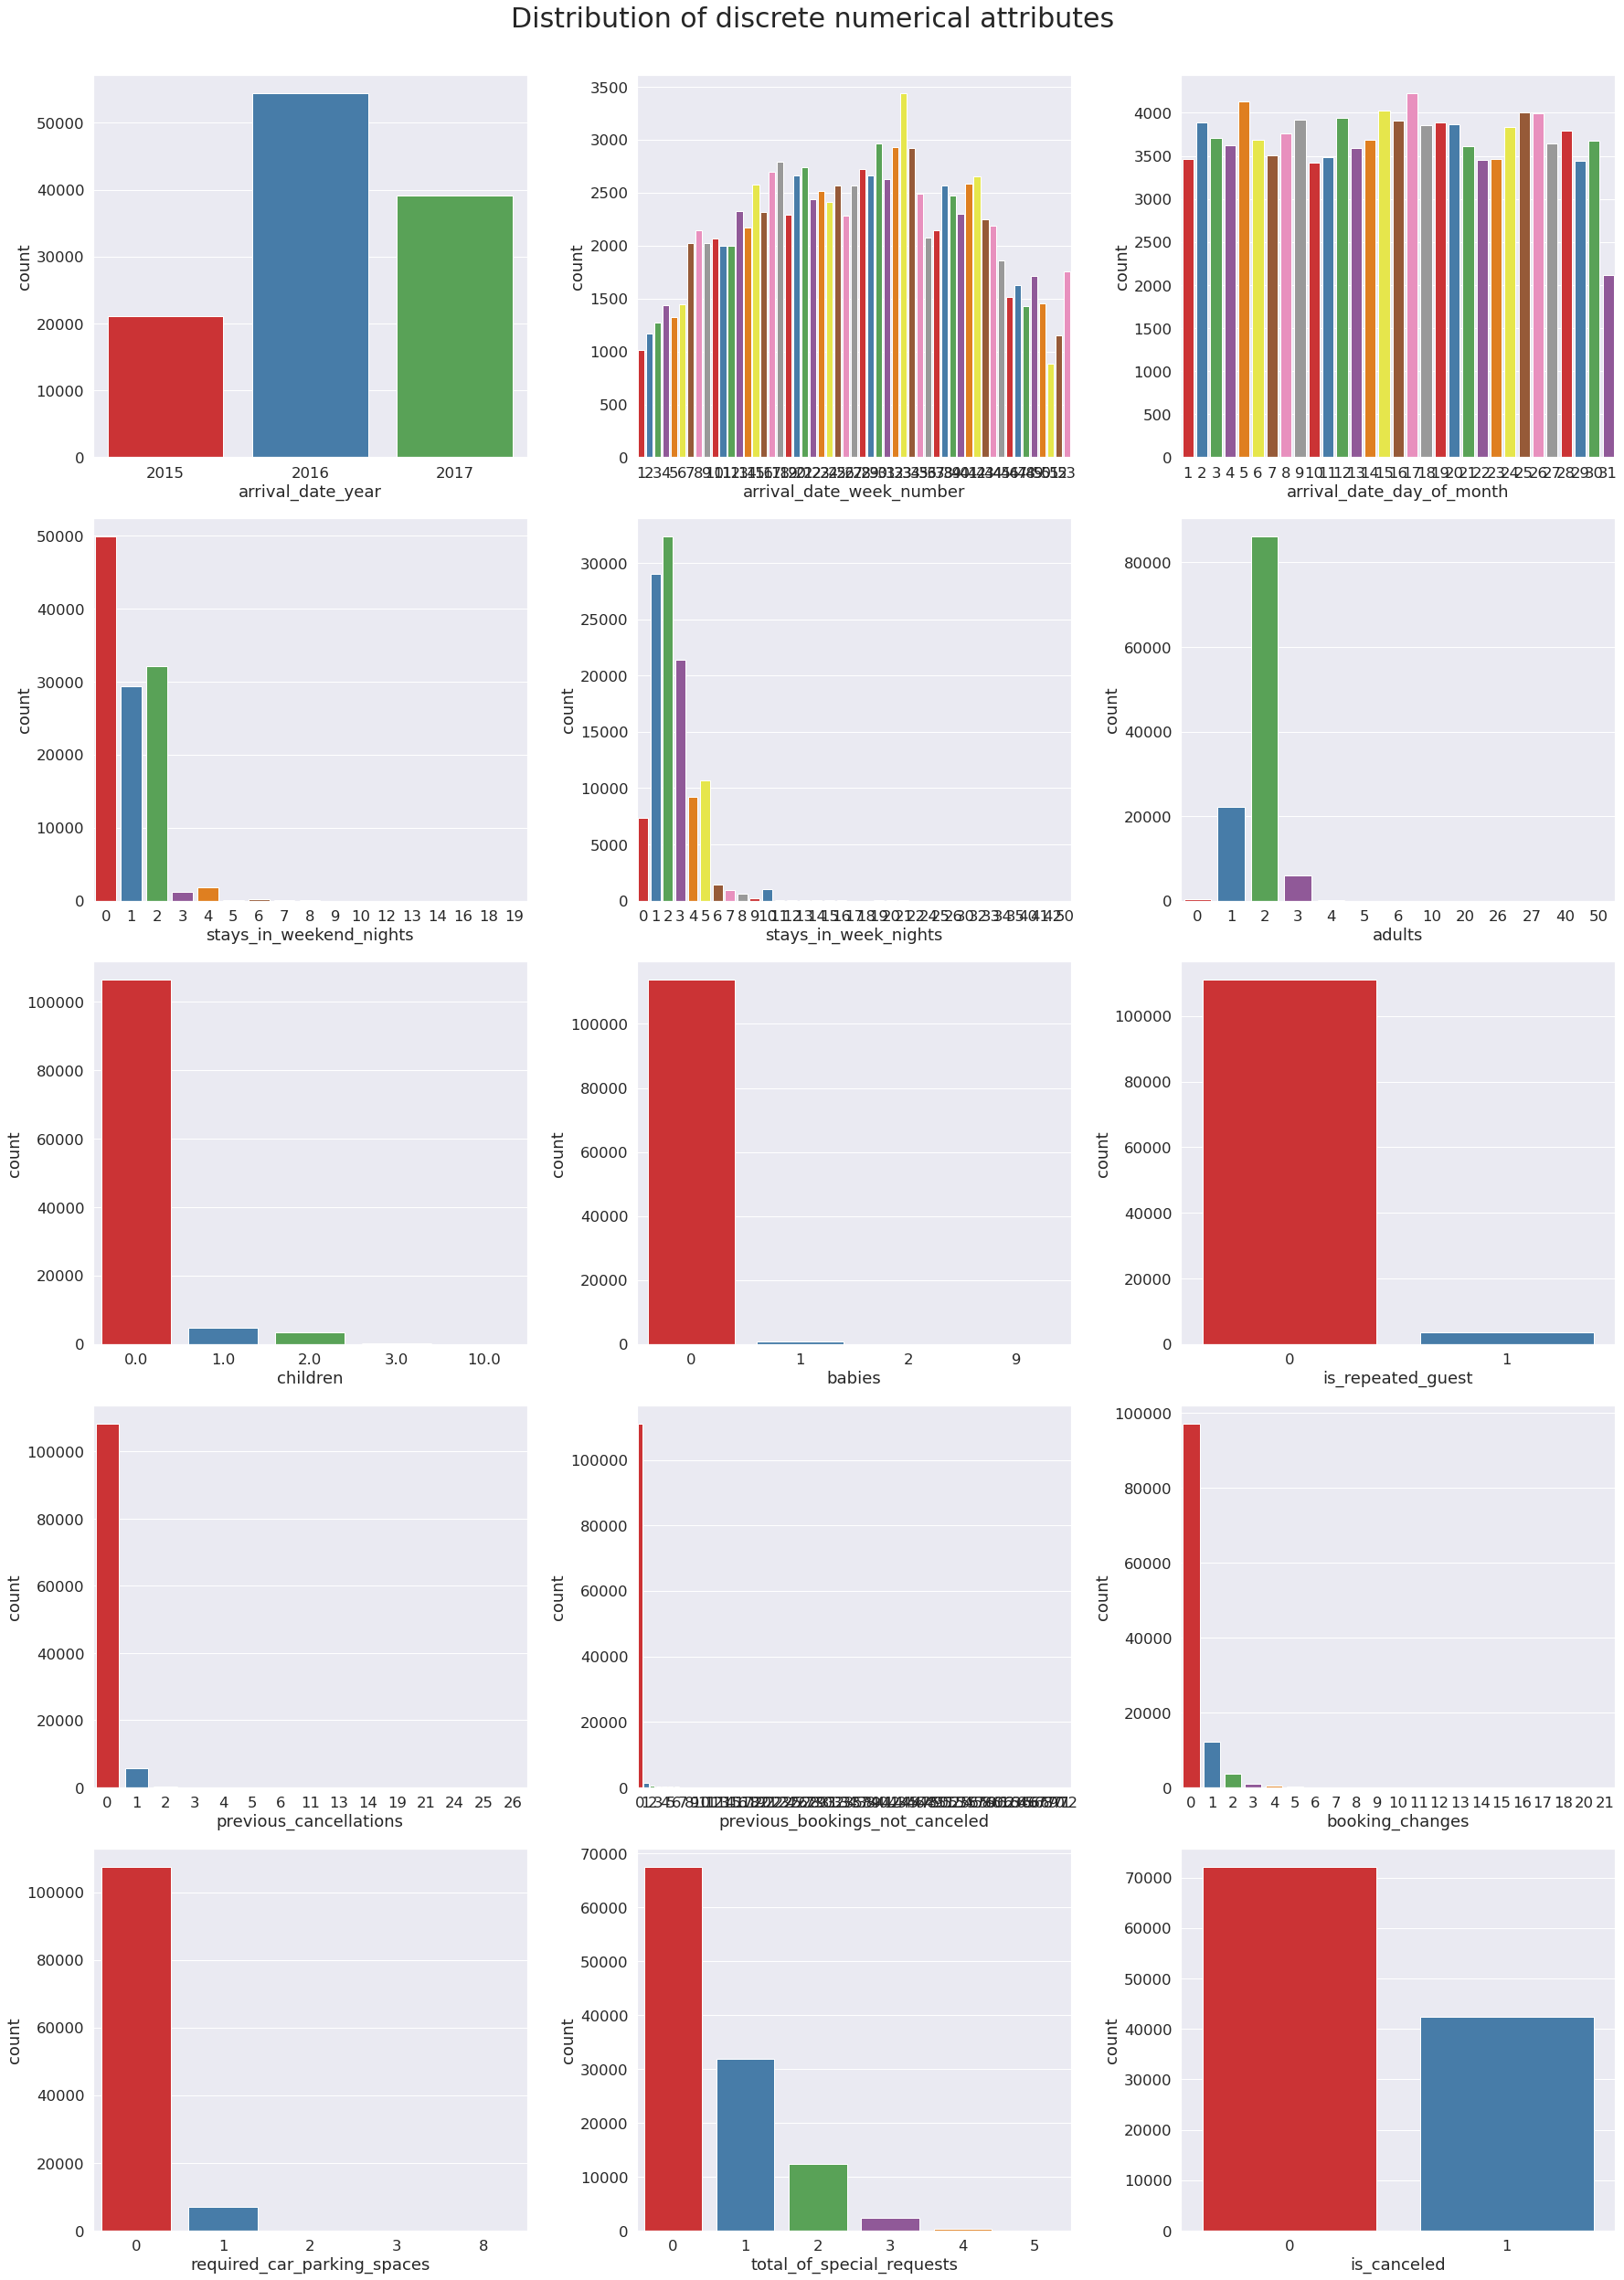

In [18]:
#Discrete numerical columns
fig = plt.figure(figsize=(25,40))
fig.suptitle('Distribution of discrete numerical attributes', size = 30 , y = 1.02)
sns.set(style = 'darkgrid')
sns.set(font_scale = 1.5)
for index,col in enumerate(discrete_num_col):
    plt.subplot(6,3,index+1)
    sns.countplot(train[col], palette='Set1')
fig.tight_layout(pad=1.0)

**Finding:**
1. Most popular years of travel industry in our data is 2016. While for same years comparison, hotel demand are highest in period of week 13 to 42 which is approximately at beginning of April to end of October
1. According to number of adults, Most of guests are couple with no children and baby in the trips.
1. Almost all reservation are new comers. Only small portions are repeated guests 
1. Most of reservations don't require any parking space.

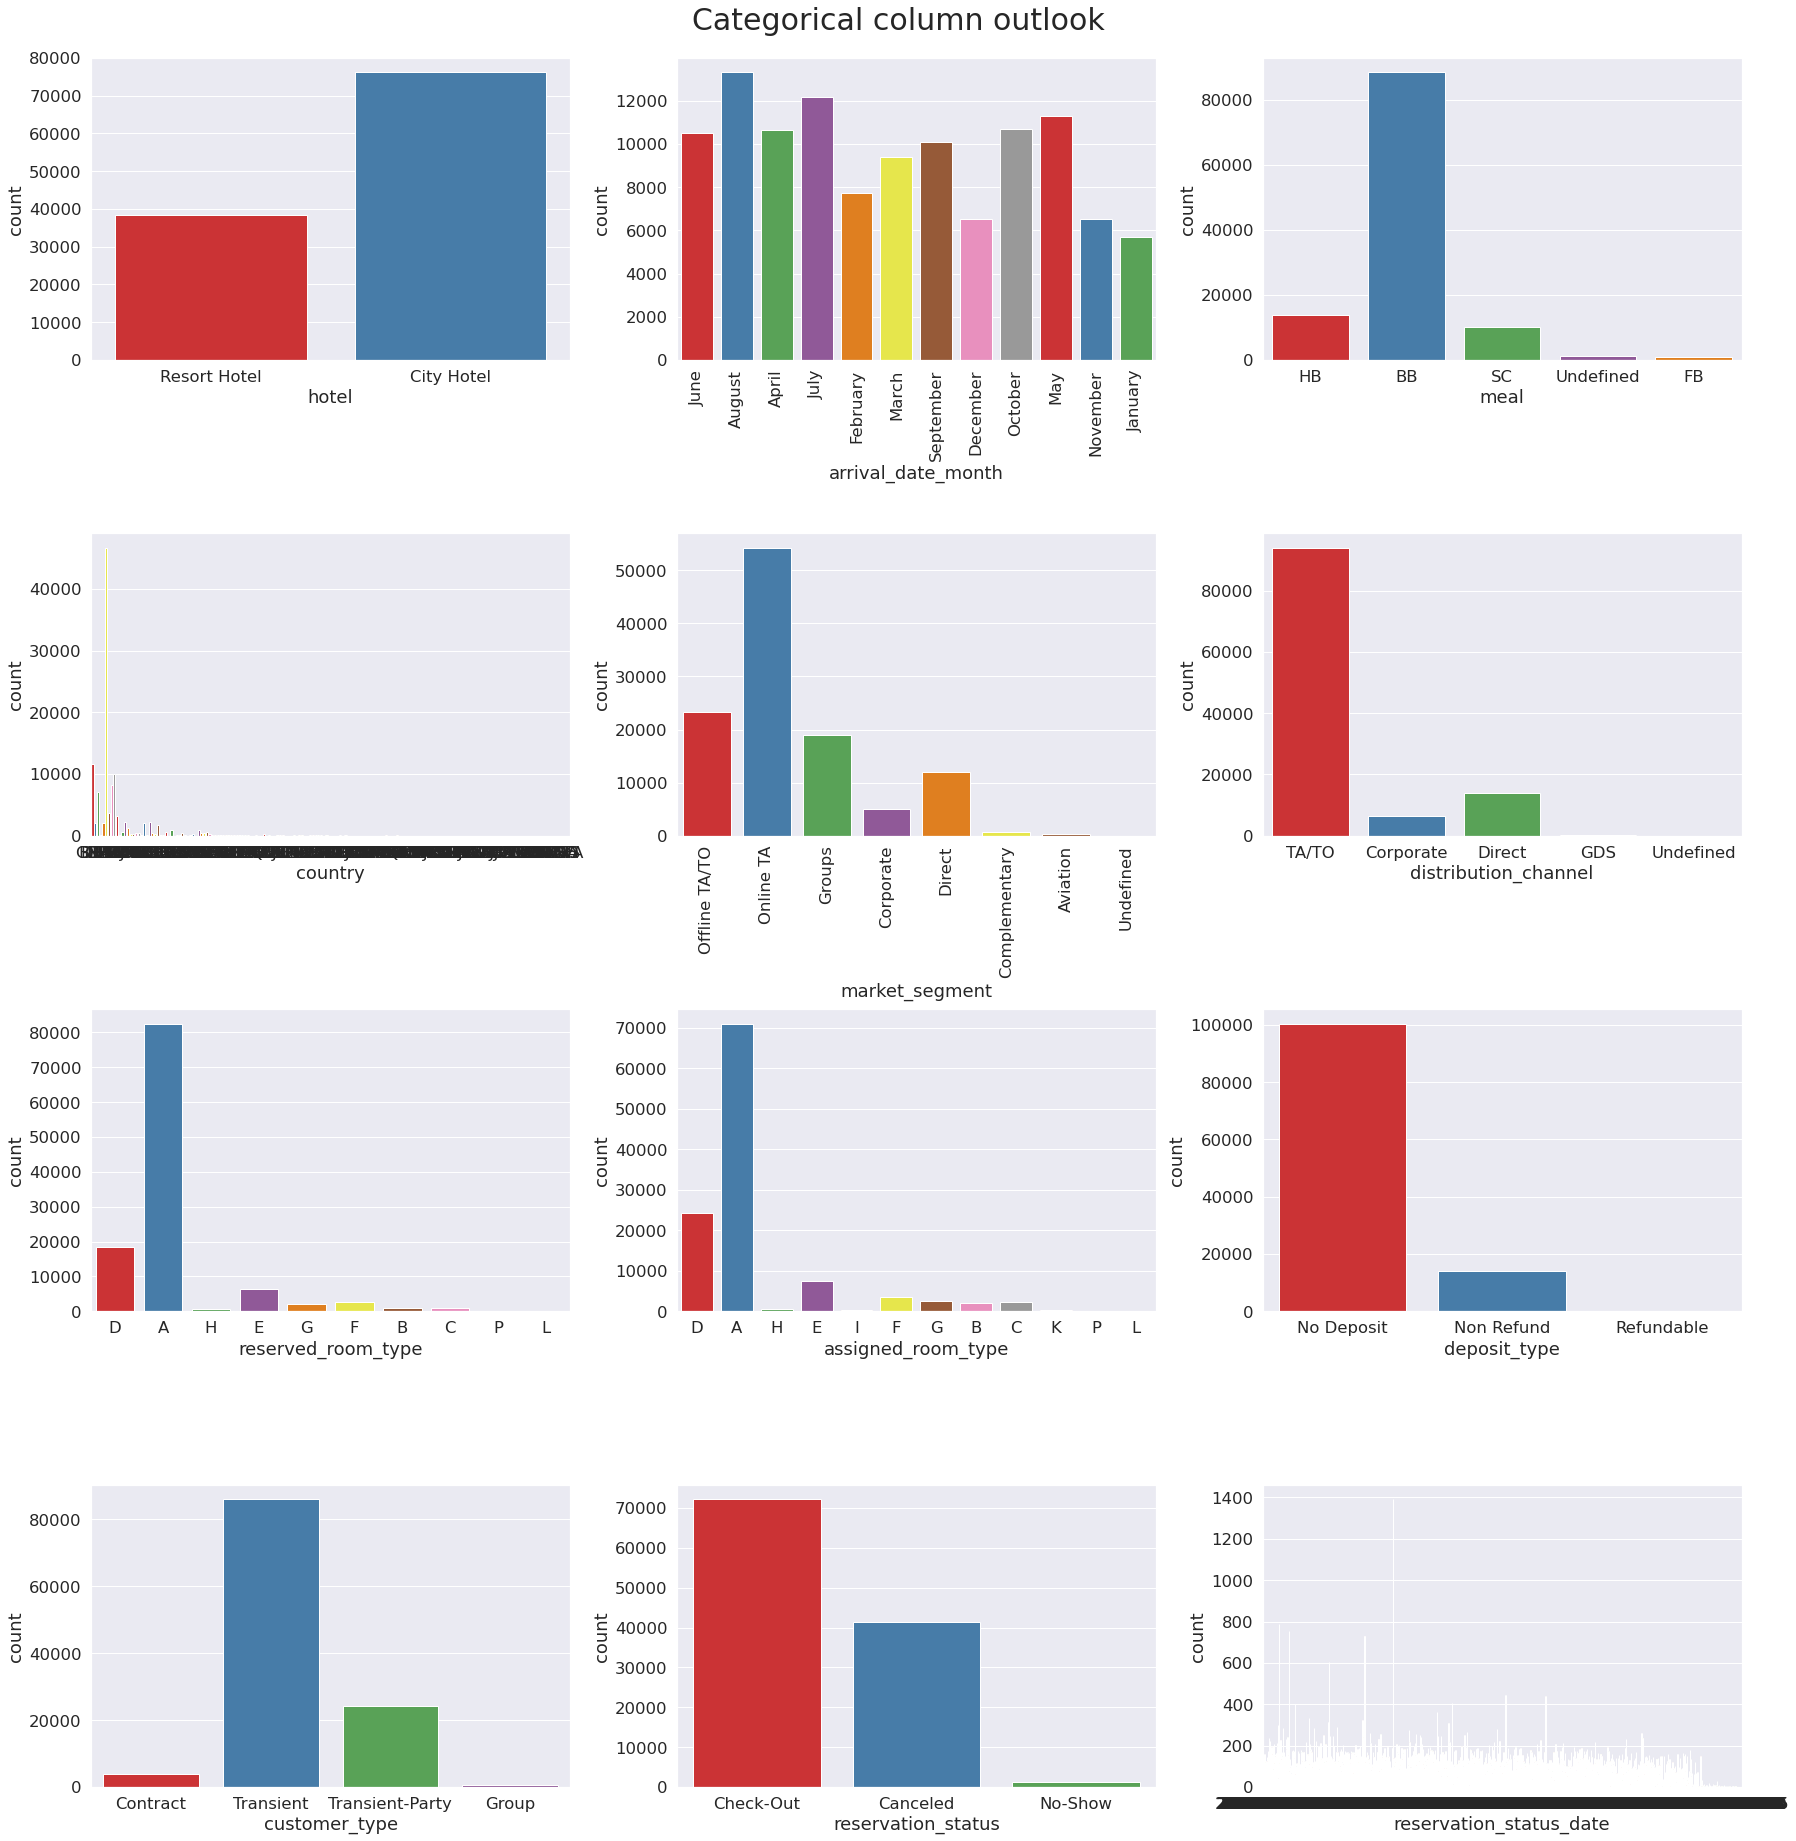

In [19]:
#Categorical columns
fig = plt.figure(figsize=(25,25))
fig.suptitle('Categorical column outlook',size=30,y=1.02)
sns.set(style='darkgrid',font_scale = 1.5)
for index,col in enumerate(cat_col):
    plt.subplot(4,3,index+1)
    ax = sns.countplot(train[col], palette='Set1')
    if col in ['arrival_date_month','market_segment']:
        ax.set_xticklabels(ax.get_xticklabels(),rotation= 90)
fig.tight_layout(pad=0.5)

**Finding**
1. 2/3 of our reservation information are city hotel
1. No. of reservations are high during April-October which corresponding to our observation above
1. Meal services : Most of reservation are made with 'Bed and Breakfast'
1. Market segment : Large part of reservation ($\geq$ 50%) were made via online travel agency following by offline TA/TO and groups
1. Distribution channel : most of reservation were distributed via TA/TO with small portion in direct sell and Coperate sell
1. Deposit type : Most of reservation require no deposit, while some were non-refundable


## Bivariate Analysis

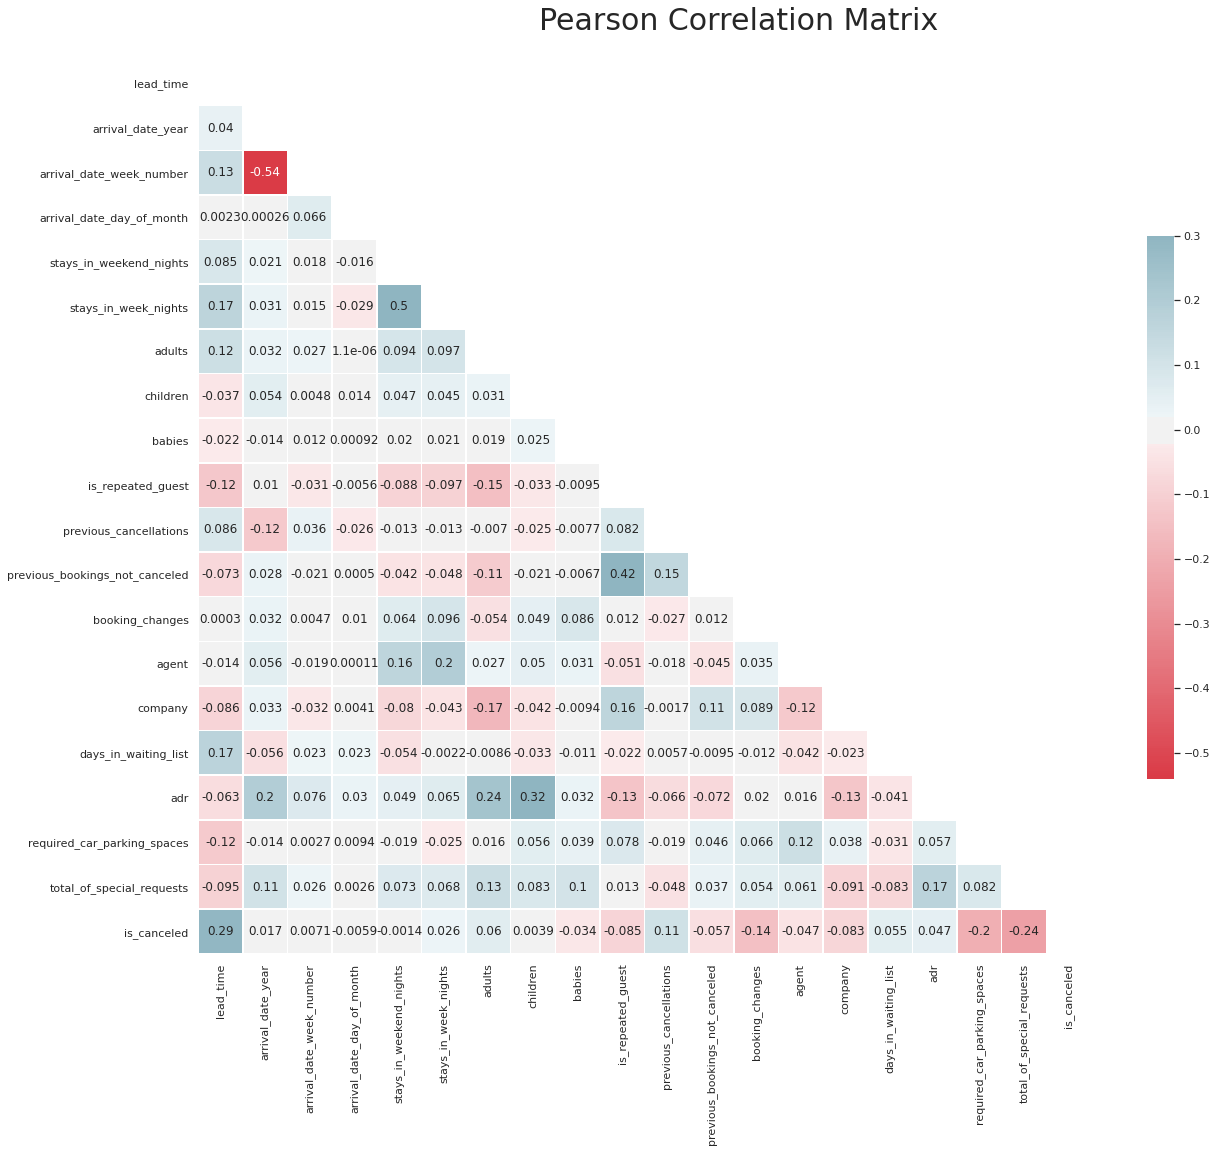

In [20]:
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
f.suptitle('Pearson Correlation Matrix',size = 30,y=0.85)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
# cmap = sns.color_palette("RdBu_r")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5,fmt='.2g', cbar_kws={"shrink": .5})

### Finding from corelation matrix
#### Factors which may lead to cancellation<br>

1. **Lead time** : reservation with more lead time (booking in advance) is more likely to be cancelled
<!-- 1. **previous cancellations** : guest with record of previous cancellation tend to cancell again -->

#### Factors which contribute for successful reservation <br>

1. **#of booking changes** : guests with booking change has tedency to visit the hotel (at the first time, guests may not available so they make booking change to the date they're available)
1. **parking space requirement** : guests who required parking spaces has lower possibility to cancel the reservation
1. **total of special requests** : guests with special requests is likely to have strong intention to visit

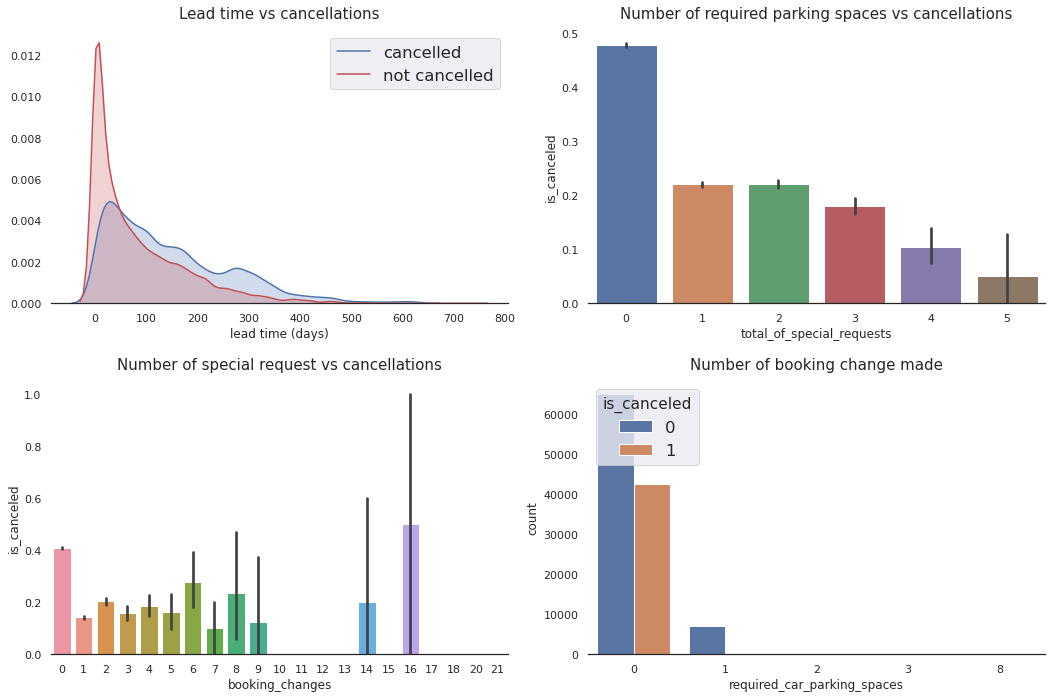

In [21]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.despine(left=True)
sns.set(font_scale=1.5)

# Plot Lead time vs cancellations
ax1 = sns.kdeplot(train[train['is_canceled'] == 1].lead_time ,shade = True, label = 'cancelled' ,color ='b', ax=axes[0, 0])
ax2 = sns.kdeplot(train[train['is_canceled'] == 0].lead_time , shade = True, label = 'not cancelled', color = 'r', ax=axes[0, 0])
ax1.set_xlabel('lead time (days)')
ax1.set_title('Lead time vs cancellations',size = 15, y = 1.02)


# Plot number of booking changes vs cancellations
ax3 = sns.barplot(x = 'booking_changes', y = 'is_canceled' ,data = train, ax=axes[1, 0])
ax3.set_title('Number of special request vs cancellations', size = 15, y = 1.02)

# Plot parking space requirement vs cancellations
ax4 = sns.countplot(x = 'required_car_parking_spaces' ,hue='is_canceled',data = train, ax=axes[1, 1])
ax4.set_title('Number of booking change made', size = 15, y = 1.02)

# Plot number of special requests vs cancellations
ax5 = sns.barplot(x = 'total_of_special_requests', y = 'is_canceled' ,data = train, ax=axes[0, 1])
ax5.set_title('Number of required parking spaces vs cancellations', size = 15, y = 1.02)

plt.setp(axes,  autoscalex_on = True);
plt.tight_layout(pad=1.0);

To support mentioned observation, I've decided to plot above figures. Let's look what it can implies,

* Guest who not canceled the reservation often have short lead time. 
* Guest with high amount of special request seem to have interest in hotel and have less cancellations than guest without special request
* Guest with some booking change (1-5) has lower possibility of cancellations than one who doesn't make any change
* Guest who demands single parking space has no cancellations!


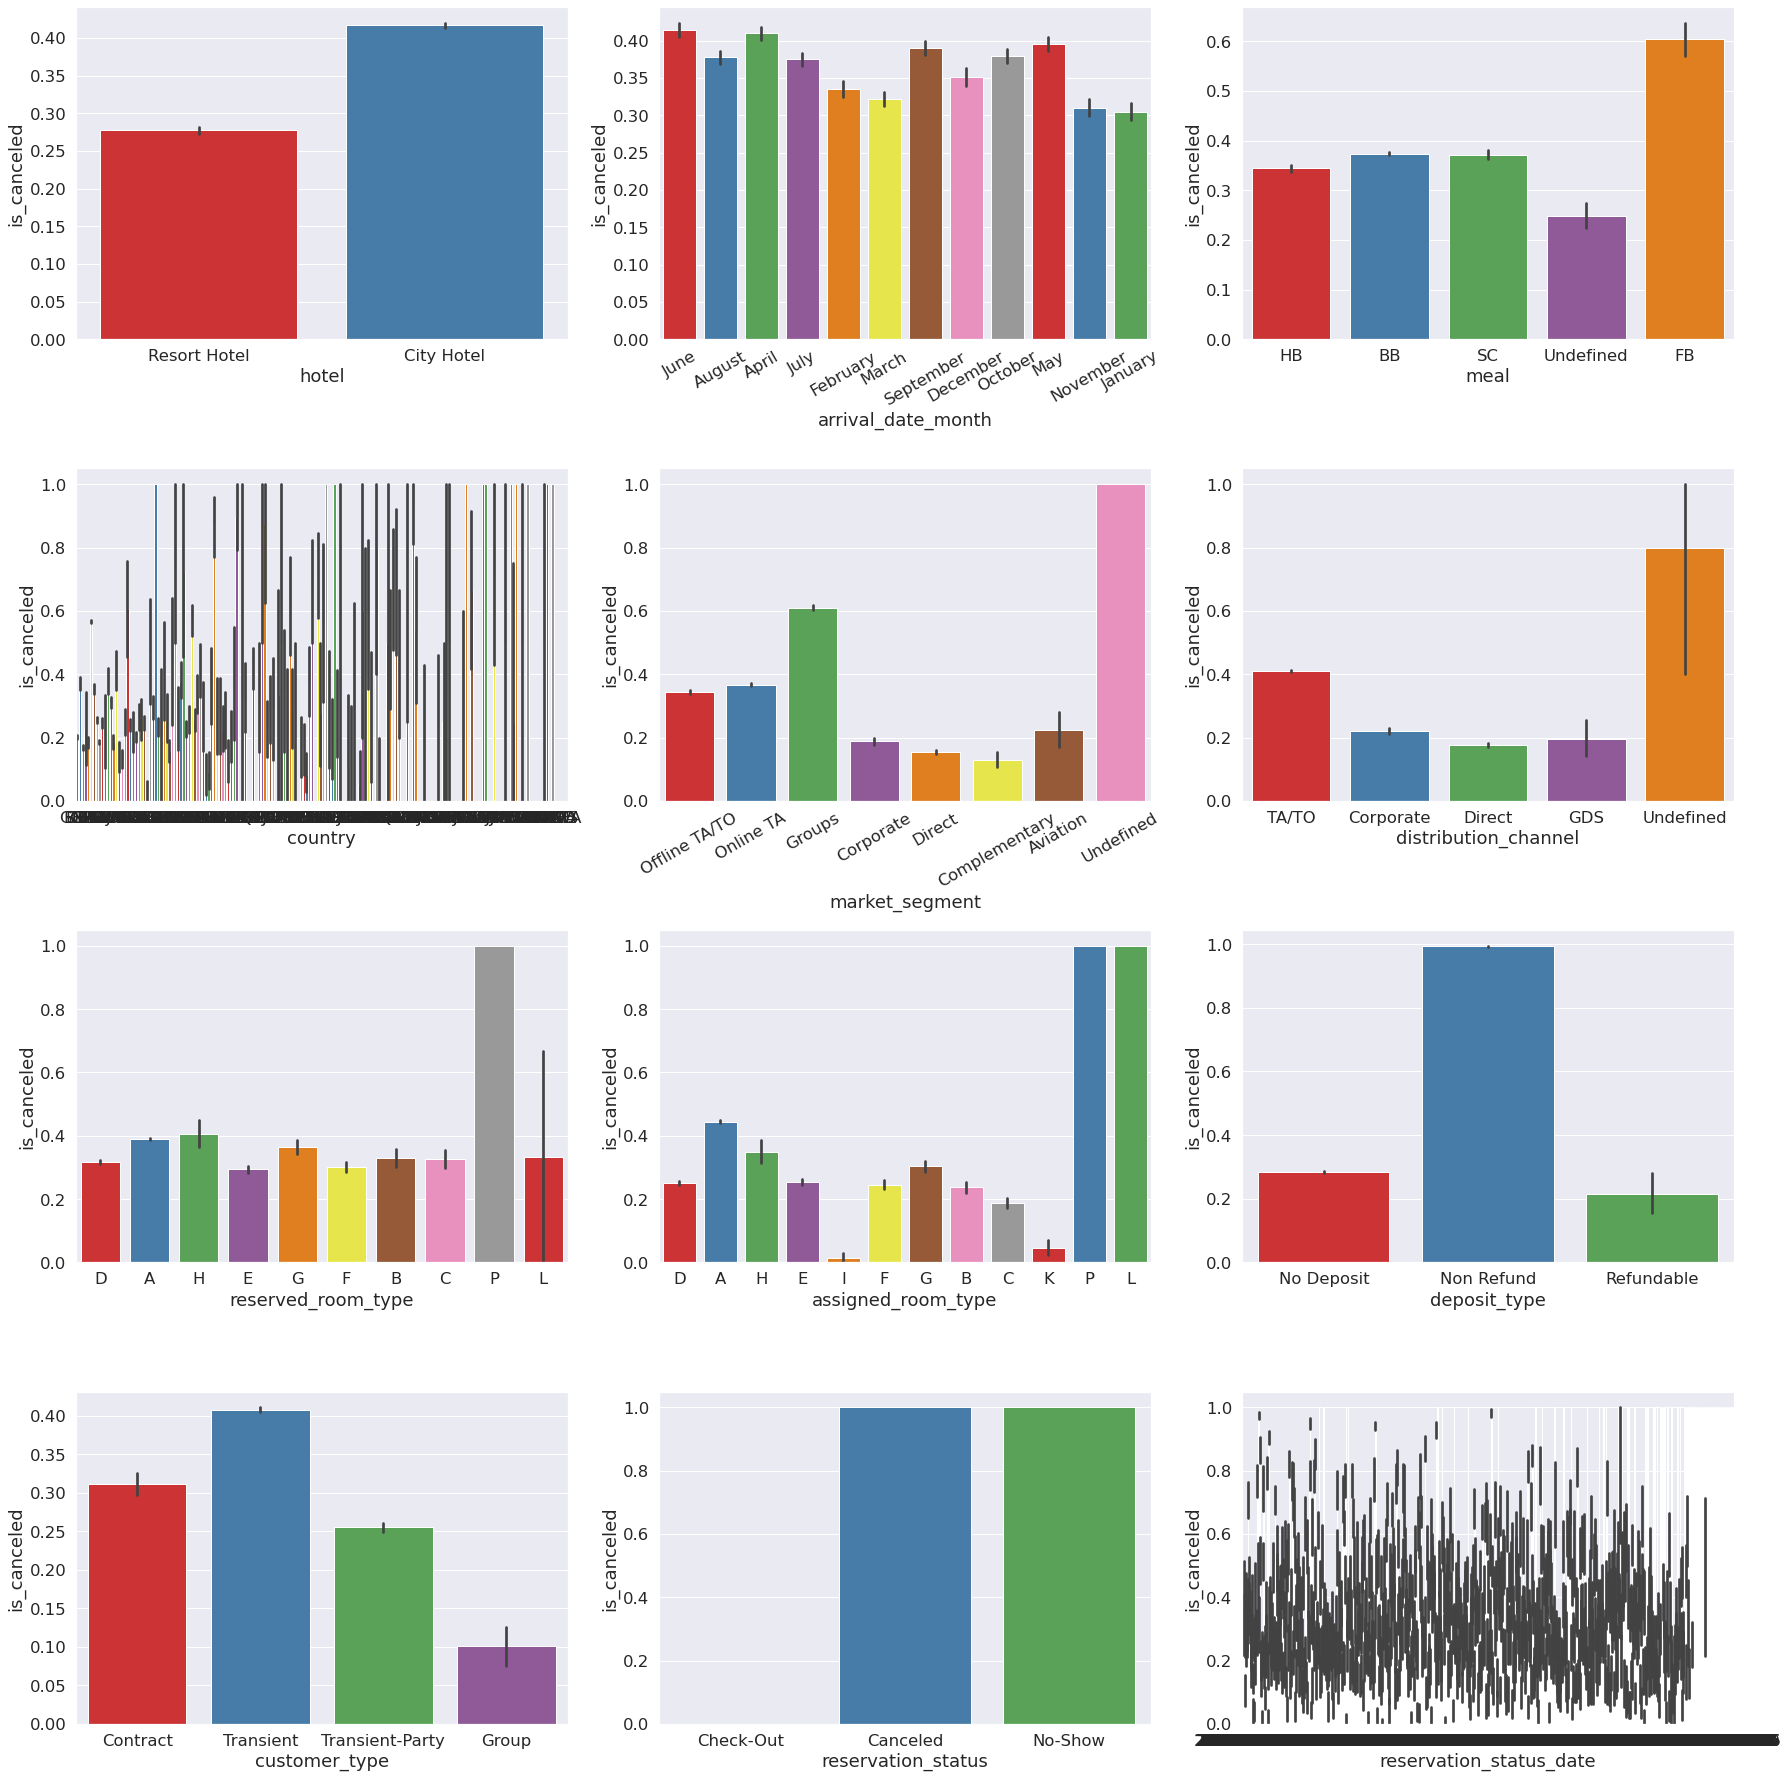

In [22]:
#Categorical columns
fig = plt.figure(figsize=(25,25))
sns.set_style('darkgrid')
for index,col in enumerate(cat_col):
    plt.subplot(4,3,index+1)
    ax = sns.barplot(x=col,y='is_canceled',data=train, palette='Set1')
    if col in ['arrival_date_month','market_segment']:
        ax.set_xticklabels(ax.get_xticklabels(),rotation= 30)
fig.tight_layout(pad=1.0)

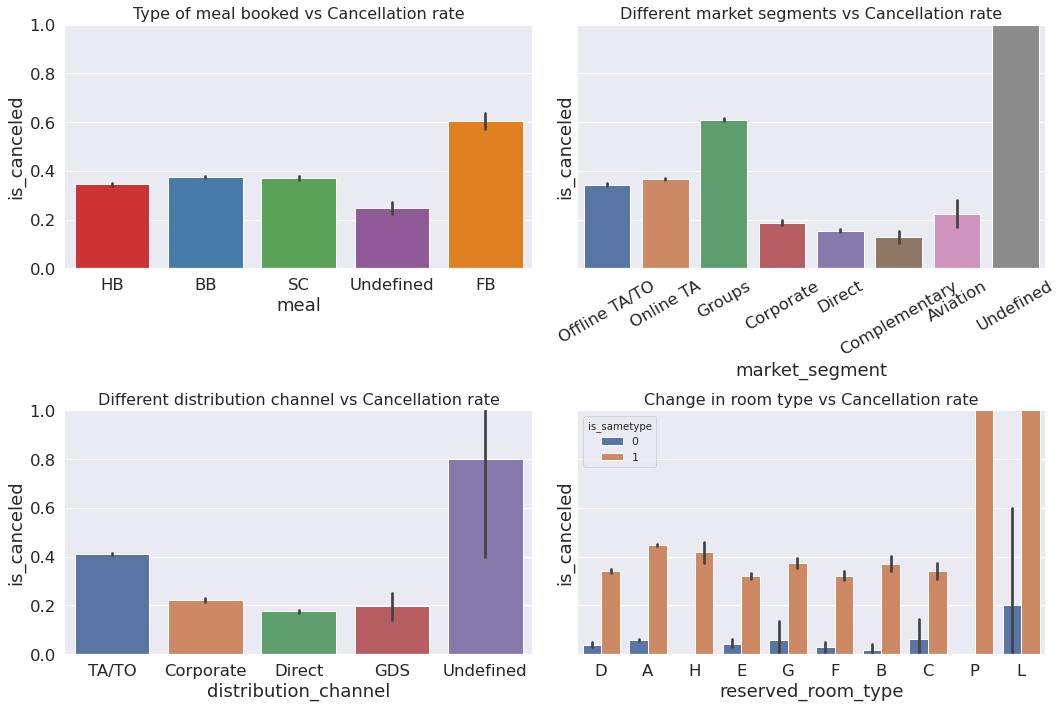

In [23]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
sns.despine(left=True)
sns.set(font_scale = 1.0)

# Type of meal booked vs Cancellation rate
ax1 = sns.barplot(x='meal',y='is_canceled',data=train, palette='Set1', ax=axes[0,0])
ax1.set_title('Type of meal booked vs Cancellation rate', size = 16)

# Different market segments vs Cancellation rate
ax2 = sns.barplot(x = 'market_segment', y = 'is_canceled' ,data = train, ax=axes[0,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation= 30)
ax2.set_title('Different market segments vs Cancellation rate', size = 16)

# Different distribution channel vs Cancellation rate
ax3 = sns.barplot(x = 'distribution_channel', y = 'is_canceled' ,data = train, ax=axes[1,0])
ax3.set_title('Different distribution channel vs Cancellation rate', size = 16)

# Change in room type vs Cancellation rate
train['is_sametype'] = np.where(train['reserved_room_type'] == train['assigned_room_type'],1,0)
ax4 = sns.barplot(x = 'reserved_room_type', y = 'is_canceled', data=train ,hue='is_sametype', ax=axes[1,1])
ax4.set_title('Change in room type vs Cancellation rate', size = 16)

plt.setp(axes,  autoscalex_on = True , ylim = [0,1]);
plt.tight_layout();

* Booking with FB – Full board (breakfast, lunch and dinner) have highest rate of cancellation
* Exclude undefined out of market segment, Groups segment have highest rate of cancellation than other segment. Reservation which was given as a complementary has lowest cancellation rate

It's very surprising that reservation with unexpected change in room type having distinctively lower rate of cancellation than reservation with unchange in room type!

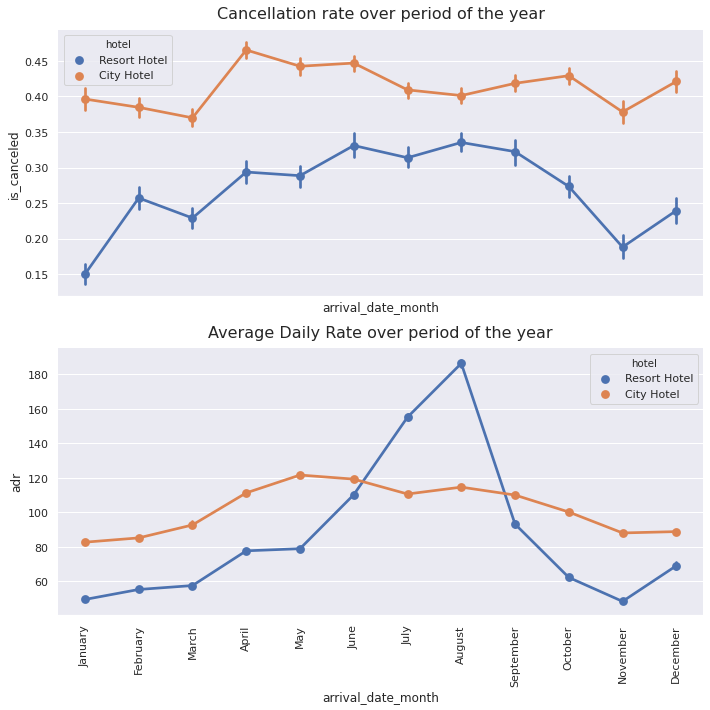

In [24]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']


# Set up the matplotlib figure
f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.despine(left=True)

# Cancellation rate over period of the year
ax1 = sns.pointplot(x="arrival_date_month", y="is_canceled",data=train,hue='hotel', order=month_order, height = 8, aspect = 1.5 ,ax=axes[0])
ax1.set_title('Cancellation rate over period of the year', size = 16, y = 1.02)

# Plot number of special requests vs cancellations
ax2 = sns.pointplot(x="arrival_date_month", y="adr", data=train, hue='hotel', order=month_order, ax=axes[1] )
ax2.set_title('Average Daily Rate over period of the year', size = 16, y = 1.02)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation= 90)
plt.setp(axes,  autoscalex_on = True);
plt.tight_layout(pad=1.0);

* Both hotel has slightly higher rate of cancellations during April to September
* City hotel has higher cancellation rate than resort hotel over all period of the year.
* From daily rate point of view, City hotel has less fluctuation in adr than resort hotel where adr start to ramp up from May and reach peak at August with about 3 times increasing from Low season period

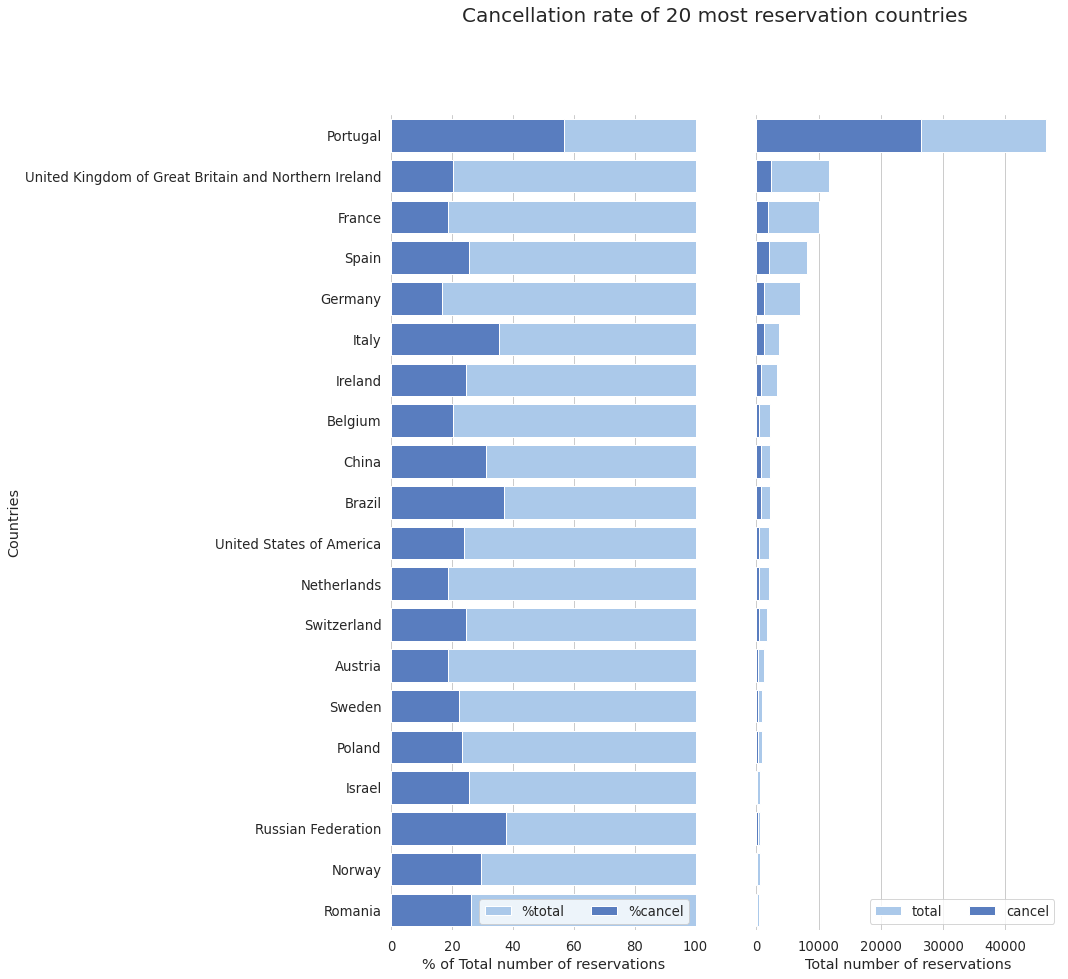

In [25]:
#read ISO3166 country code
code = pd.read_csv('../input/iso3166-country-code-pair/country-code.csv')
code = code.append({'English short name (using title case)': ' Unknown', 'Alpha-3 code':'UNK'},ignore_index=True)
#merge with our data
total = train['country'].value_counts().to_frame().rename(columns={'country':'total'})
total = code.merge(total,left_on='Alpha-3 code',right_index=True,how = 'inner')

confirm = train[train['is_canceled']==0]['country'].value_counts().to_frame().rename(columns={'country':'confirm'})
cancel = train[train['is_canceled']==1]['country'].value_counts().to_frame().rename(columns={'country':'cancel'})

merge1 = total.merge(cancel,left_on='Alpha-3 code',right_index=True,how='outer')
merge2 = merge1.merge(confirm,left_on='Alpha-3 code',right_index=True,how='outer')
merge2['%cancel'] = merge2['cancel']/merge2['total']*100
merge2['%confirm'] = 100 - merge2['%cancel']
merge2['%total'] = 100
merge2 = merge2.sort_values(by='total',ascending=False)

#subplot 1,2
sns.set(style="whitegrid", font_scale = 1.2)

# Initialize the matplotlib figure
f, axes = plt.subplots(1,2,figsize=(12, 15),sharey=True)
f.suptitle('Cancellation rate of 20 most reservation countries', fontsize=20)

# Plot % total number of reservation
sns.set_color_codes("pastel")
ax1 = sns.barplot(x="%total", y="English short name (using title case)", data=merge2.iloc[:20,:],
            label="%total", color="b", ax=axes[0])

# Plot % of canceled reservation
sns.set_color_codes("muted")
ax2 = sns.barplot(x="%cancel", y="English short name (using title case)", data=merge2.iloc[:20,:],
            label="%cancel", color="b",ax=axes[0])

# Add a legend and informative axis label
ax1.legend(ncol=2, loc="lower right", frameon=True)
ax1.set(xlim=(0, 100), ylabel="Countries",
       xlabel="% of Total number of reservations")
sns.despine(left=True, bottom=True)


# Plot the total number of reservation
sns.set_color_codes("pastel")
ax3 = sns.barplot(x="total", y="English short name (using title case)", data=merge2.iloc[:20,:],
            label="total", color="b",ax=axes[1])

# Plot number of canceled reservation
sns.set_color_codes("muted")
ax4 = sns.barplot(x="cancel", y="English short name (using title case)", data=merge2.iloc[:20,:],
            label="cancel", color="b",ax=axes[1])

# Add a legend and informative axis label
ax3.legend(ncol=2, loc="lower right", frameon=True)
ax3.set(ylabel=" ",xlabel="Total number of reservations")
sns.despine(left=True, bottom=True)


From top 20 most reservation coutries, Portugal has highest rate of cancellation (nearly 60%). But we can not neglect them. Since they are largest customer segment and number of their confirmed booking alone still outnumbered others country. 

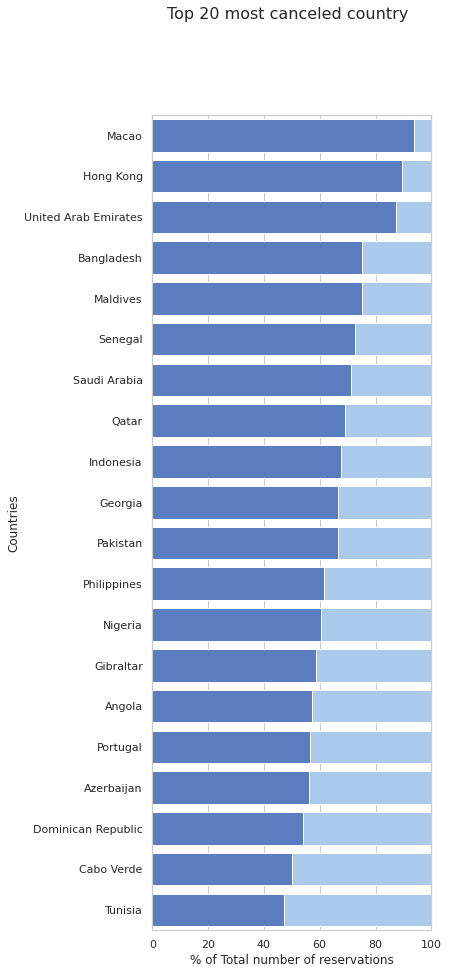

In [26]:
sns.set(style="whitegrid");

# Initialize the matplotlib figure
f, axes = plt.subplots(figsize=(5, 15));
f.suptitle('Top 20 most canceled country', fontsize=16);

# Plot the total crashes
sns.set_color_codes("pastel")
ax1 = sns.barplot(x="%total", y="English short name (using title case)", data=merge2.sort_values(by='%cancel',ascending=False)[merge2['total'] > 10 ].iloc[:20,:],
            label="%total", color="b");

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
ax2 = sns.barplot(x="%cancel", y="English short name (using title case)", data=merge2.sort_values(by='%cancel',ascending=False)[merge2['total'] > 10 ].iloc[:20,:],
            label="%cancel", color="b");
ax2.set(xlim=(0, 100), ylabel="Countries",
       xlabel="% of Total number of reservations");

Visitors from Macao has highest rate of cancellation (more than 90%)

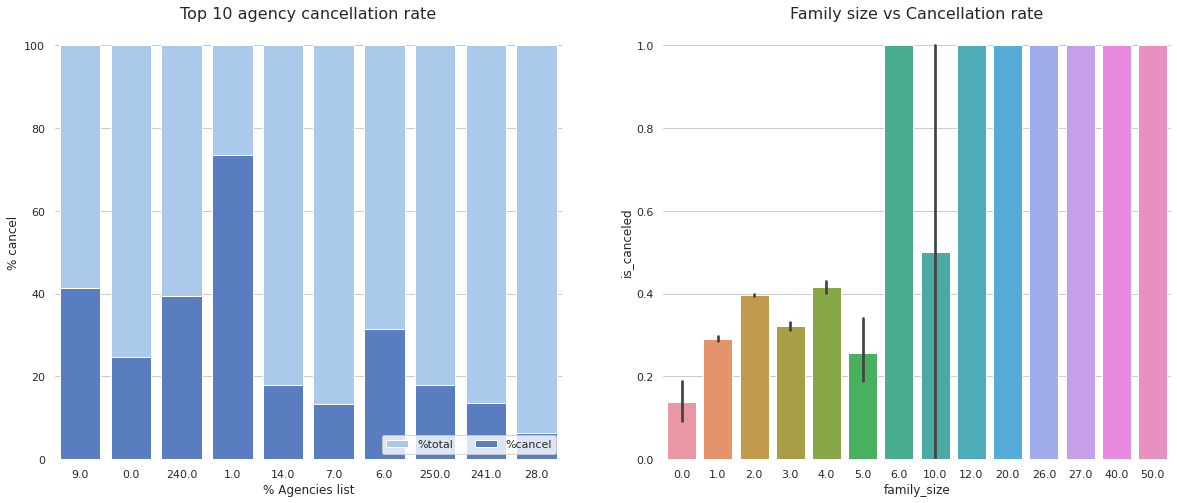

In [27]:
total = train['agent'].value_counts().to_frame().rename(columns={'agent':'total'})

confirm = train[train['is_canceled']==0]['agent'].value_counts().to_frame().rename(columns={'agent':'confirm'})
cancel = train[train['is_canceled']==1]['agent'].value_counts().to_frame().rename(columns={'agent':'cancel'})
merge1 = total.merge(cancel,left_index=True,right_index=True,how='outer')
merge2 = merge1.merge(confirm,left_index=True,right_index=True,how='outer')
merge2['%cancel'] = merge2['cancel']/merge2['total']*100
merge2['%confirm'] = 100 - merge2['%cancel']
merge2['%total'] = 100
merge2 = merge2.sort_values(by='total',ascending=False)
merge2 = merge2.reset_index().rename(columns={'index':'agent'})
merge2['agent'] = merge2['agent'].astype(str)

# Initialize the matplotlib figure
f, axes = plt.subplots(1,2,figsize=(20, 8))

# Plot total cancellation
sns.set_color_codes("pastel")
ax1 = sns.barplot(x="agent", y="%total", data=merge2.iloc[:10,:],
            label="%total", color="b", order = merge2.iloc[:10,:].agent.tolist(), ax=axes[0])

# Plot canceled made by each agency
sns.set_color_codes("muted")
ax2 = sns.barplot(x="agent", y="%cancel", data=merge2.iloc[:10,:],
            label="%cancel", color="b", order = merge2.iloc[:10,:].agent.tolist(), ax=axes[0])

# Add a legend and informative axis label
ax1.legend(ncol=2, loc="lower right", frameon=True)
ax1.set(ylabel="% cancel",
       xlabel="% Agencies list")
ax1.set_title('Top 10 agency cancellation rate', fontsize=16)

#Plot family size vs cancellation rate
train['family_size'] = train['adults'] + train['children'] + train['babies']
train['family_size']


ax3 = sns.barplot(x='family_size',y='is_canceled',data=train, ax=axes[1])
ax3.set_title('Family size vs Cancellation rate', fontsize=16)
sns.despine(left=True, bottom=True)


* Reservation made by Agency ID=1.0 have higher possiblity of cancellations than other agency
* Almost all group visitors canceled their reservations

# Data Preprocessing

Look what we have done in exploratory data analysis

1. We have decide to impute missing value of different feature with different techniques 
1. We have also included feature engineering to create new feature like 'family_size', 'stay_duration' and 'is_sametype'

This step can be done manually, but for future reproduction, I decide to put this into pipeline as shown below.

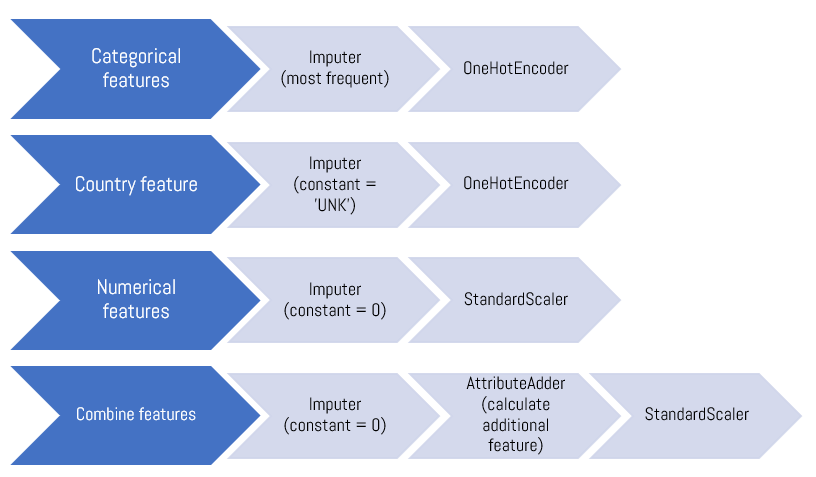

In [28]:
from IPython.display import Image
Image('../input/hotelbookingdemandwl/pipeline.png', width= 500, height = 500)

In [29]:
#Categorical columns will include preprocessing step of imputing missing value --> one hot encoding
cat_col = ['arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'agent', 
 'company', 
 'customer_type',
 'is_repeated_guest']

country_col = ['country']

num_col = ['arrival_date_day_of_month',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'lead_time',
 'adr']


combine_col = [ 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',]

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin


class AttributeAdder(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        stay_duration = X[:,0] + X[:,1]
        family_size = X[:,2] + X[:,3] + X[:,4]
        return np.c_[X,stay_duration,family_size]
        

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'constant',fill_value=0)),
    ('std_scaler', StandardScaler()) #z-score scaling
])

#Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')) #convert categorical columns into one hot vectors
])

#Country pipeline
cou_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNK')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Categorical pipeline for tree based model
cat_pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder()) #convert categorical columns into one hot vectors
])

#Country pipeline for tree based model
cou_pipeline_tree = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNK')),
    ('encoder', OrdinalEncoder())
])

#Combine attribute pipeline

com_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'constant',fill_value=0)),
    ('AttributeAdder',AttributeAdder()),
    ('std_scaler', StandardScaler()) #z-score scaling
])

#Preprocessing_onehot
preprocessing_onehot = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col),
    ('country', cou_pipeline, country_col),
    ('combine', com_pipeline, combine_col)
])

#Preprocessing_ordinal
preprocessing_ordinal = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline_tree, cat_col),
    ('country', cou_pipeline_tree, country_col),
    ('combine', com_pipeline, combine_col)
])


# Model evaluation

Since our task is to predict whether given reservation will be canceled or not? (This is a supervised classification problem). Therefore I decide to compare following algorithms

1. LogisticRegression
1. Support Vector Machine with Polynomial Kernel
1. Support Vector Machine with RBF kernel
1. Random Forest Classifier
1. Extreme Gradient Boosting (XGBoost) Classifier
1. Adaptive Gradient Boosting (AdaBoost) Classifier

All algorithm will be compared based on thier default configuration by scikit-learn.

Comparison will be conducted with cross validation method. Only best perform model will be selected for further fine tuning

In [32]:
np.random.seed(1)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb


X_train_prepared = preprocessing_onehot.fit_transform(X_train)
model_list = [('LogisticsRegression', LogisticRegression()),
#          ('PolyKernelSVC', SVC(kernel = 'poly')), 
#          ('RBFKernelSVC', SVC(kernel='rbf')),extremely long training time
         ('RandomForestClassifer', RandomForestClassifier()),
         ('XGBClassifier', xgb.XGBClassifier()),
         ('AdaBoostClassifier', AdaBoostClassifier())
        ]
model_score_onehot = []
model_score_ordinal = []

In [33]:
# %%script false --no-raise-error
print('OneHotEncoding')
for m in model_list:
    model = m[1]
    score = cross_val_score(model,X_train_prepared,y_train,cv=4, scoring='accuracy');
    print(f'{m[0]} score = {round(score.mean(),3)}+/-{round(np.std(score),3)}')
    model_score_onehot.append([m[0],score.mean()])
    
# print('---------------------------------------')
# print('OrdinalEncoding')
# for m in model_list:
#     model = m[1]
#     score = cross_val_score(model,preprocessing_ordinal.fit_transform(X_train),y_train,cv=4, scoring='accuracy');
#     print(f'{m[0]} score = {round(score.mean(),3)}+/-{round(np.std(score),3)}')
#     model_score_ordinal.append([m[0],score.mean()])

OneHotEncoding
LogisticsRegression score = 0.826+/-0.002
RandomForestClassifer score = 0.885+/-0.001
XGBClassifier score = 0.87+/-0.002
AdaBoostClassifier score = 0.827+/-0.001


Evaluation result show that RandomForestClassifer (which has the highest cross validation score) are the best among others. However it also have extremely long training time compare to XGBoost and AdaBoost model. We'll try to tune 3 model included
1. RandomForestClassifier
1. XGBoost
1. AdaBoost

and try to find best model in perspective of accuracy and training time

# Hyperparameters tuning

## Learning curve

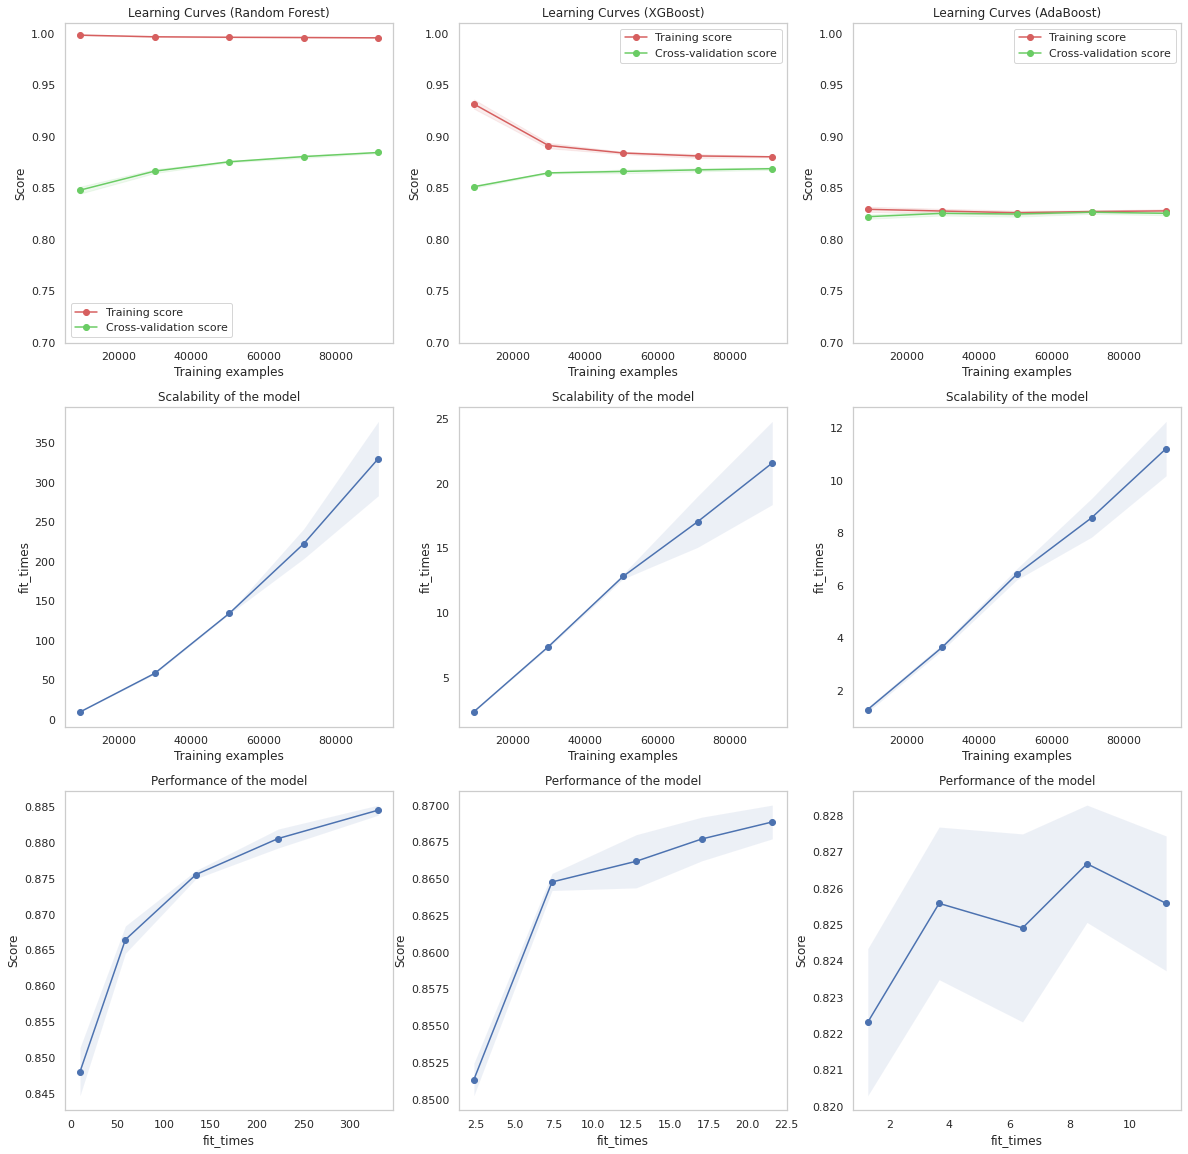

In [34]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(20, 20))

title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)

plot_learning_curve(RandomForestClassifier(), title, X_train_prepared, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_learning_curve(xgb.XGBClassifier(), title, X_train_prepared, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (AdaBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_learning_curve(AdaBoostClassifier(), title, X_train_prepared, y_train, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()

## Tuning with RandomizedSearchCV

In [35]:
from sklearn.model_selection import RandomizedSearchCV
params_RFC = [{
    'n_estimators' : np.arange(100,301,10),
    'max_depth' : np.arange(10,51,5),
    'min_samples_split' : np.arange(10,201,5),
    'min_samples_leaf' : np.arange(10,201,5) 
}]

params_XGB = [{
    'n_estimators' : np.arange(100,301,10),
    'max_depth' : np.arange(10,51,5),
    'learning_rate' : [0.001,0.003,0.01,0.03,0.1,0.3],
    'reg_lambda' :  [0.001,0.003,0.01,0.03,0.1,0.3]
}]

params_ADA = [{
    'n_estimators' : np.arange(100,301,10),
    'learning_rate' : [0.001,0.003,0.01,0.03,0.1,0.3],
}]

#Optimize Random Forest
clf_rfc = RandomizedSearchCV(RandomForestClassifier(),params_RFC,scoring='accuracy',n_jobs=-1,cv=4, n_iter = 30, random_state=1)
clf_rfc.fit(X_train_prepared,y_train)
print(f'RandomForest : Best combination of hyperparameters yeild result in {round((clf_rfc.best_score_*100),3)}% accuracy')

#Optimize XGB
clf_xgb = RandomizedSearchCV(xgb.XGBClassifier(),params_XGB,scoring='accuracy',n_jobs=-1,cv=4, n_iter = 30, random_state=1)
clf_xgb.fit(X_train_prepared,y_train)
print(f'XGBboost : Best combination of hyperparameters yeild result in {round((clf_xgb.best_score_*100),3)}% accuracy')

clf_ada = RandomizedSearchCV(AdaBoostClassifier(),params_ADA,scoring='accuracy',n_jobs=-1,cv=4, n_iter = 30, random_state=1)
clf_ada.fit(X_train_prepared,y_train)
print(f'Adaboost : Best combination of hyperparameters yeild result in {round((clf_ada.best_score_*100),3)}% accuracy')

RandomForest : Best combination of hyperparameters yeild result in 82.349% accuracy
XGBboost : Best combination of hyperparameters yeild result in 88.845% accuracy
Adaboost : Best combination of hyperparameters yeild result in 83.194% accuracy


In [36]:
import joblib
#if model perform better than baseline model then save it.
if clf_rfc.best_score_ > model_score_onehot[1][1]:
    model_rfc = clf_rfc.best_estimator_
    joblib.dump(model_rfc, 'model_rfc.pkl')
    
if clf_xgb.best_score_ > model_score_onehot[2][1]:
    model_xgb = clf_xgb.best_estimator_
    joblib.dump(model_xgb, 'model_xgb.pkl')
    
if clf_ada.best_score_ > model_score_onehot[3][1]:
    model_ada = clf_ada.best_estimator_
    joblib.dump(model_ada, 'model_ada.pkl')
    

# Result and Discussion

In [37]:
#Original model = _ori

rfc_ori = model_list[1][1]
rfc_ori.fit(X_train_prepared,y_train)

xgb_ori = model_list[2][1]
xgb_ori.fit(X_train_prepared,y_train)

ada_ori = model_list[3][1]
ada_ori.fit(X_train_prepared,y_train)


#Finetune model = _tune
rfc_tune = clf_rfc.best_estimator_
rfc_tune.fit(X_train_prepared,y_train)

xgb_tune = clf_xgb.best_estimator_
xgb_tune.fit(X_train_prepared,y_train)

ada_tune = clf_ada.best_estimator_
ada_tune.fit(X_train_prepared,y_train)

AdaBoostClassifier(learning_rate=0.3, n_estimators=290)

In [38]:
from sklearn.metrics import accuracy_score

X_test_prepared = preprocessing_onehot.transform(X_test)

#RFC model
y_pred_rfc_ori = rfc_ori.predict(X_test_prepared)
print(f'rfc_ori accuracy on test set = {round(accuracy_score(y_test,y_pred_rfc_ori),3)*100}%')
y_pred_rfc_tune = rfc_tune.predict(X_test_prepared)
print(f'rfc_tune accuracy on test set = {round(accuracy_score(y_test,y_pred_rfc_tune),3)*100}%')
print('--------------------------')

#XGB model
y_pred_xgb_ori = xgb_ori.predict(X_test_prepared)
print(f'xgb_ori accuracy on test set = {round(accuracy_score(y_test,y_pred_xgb_ori),3)*100}%')
y_pred_xgb_tune = xgb_tune.predict(X_test_prepared)
print(f'xgb_tune accuracy on test set = {round(accuracy_score(y_test,y_pred_xgb_tune),3)*100}%')
print('--------------------------')

#ADA model
y_pred_ada_ori = ada_ori.predict(X_test_prepared)
print(f'ada_ori accuracy on test set = {round(accuracy_score(y_test,y_pred_ada_ori),3)*100}%')
y_pred_ada_tune = ada_tune.predict(X_test_prepared)
print(f'ada_tune accuracy on test set = {round(accuracy_score(y_test,y_pred_ada_tune),3)*100}%')
print('--------------------------')

rfc_ori accuracy on test set = 89.0%
rfc_tune accuracy on test set = 82.89999999999999%
--------------------------
xgb_ori accuracy on test set = 87.2%
xgb_tune accuracy on test set = 89.2%
--------------------------
ada_ori accuracy on test set = 82.6%
ada_tune accuracy on test set = 83.0%
--------------------------


Our candidate model (Random Forest Classifier with fine-tuned parameters) has accuracy of 88.7% on cross-validation set and 89.2% on test set

## Feature importance

In [39]:
A = preprocessing_onehot.transformers_[0][2]
B = preprocessing_onehot.transformers_[1][1][1].get_feature_names().tolist()
C = preprocessing_onehot.transformers_[2][1][1].get_feature_names().tolist()
D = preprocessing_onehot.transformers_[3][2]
D.append('stay_duration')
D.append('family_size')

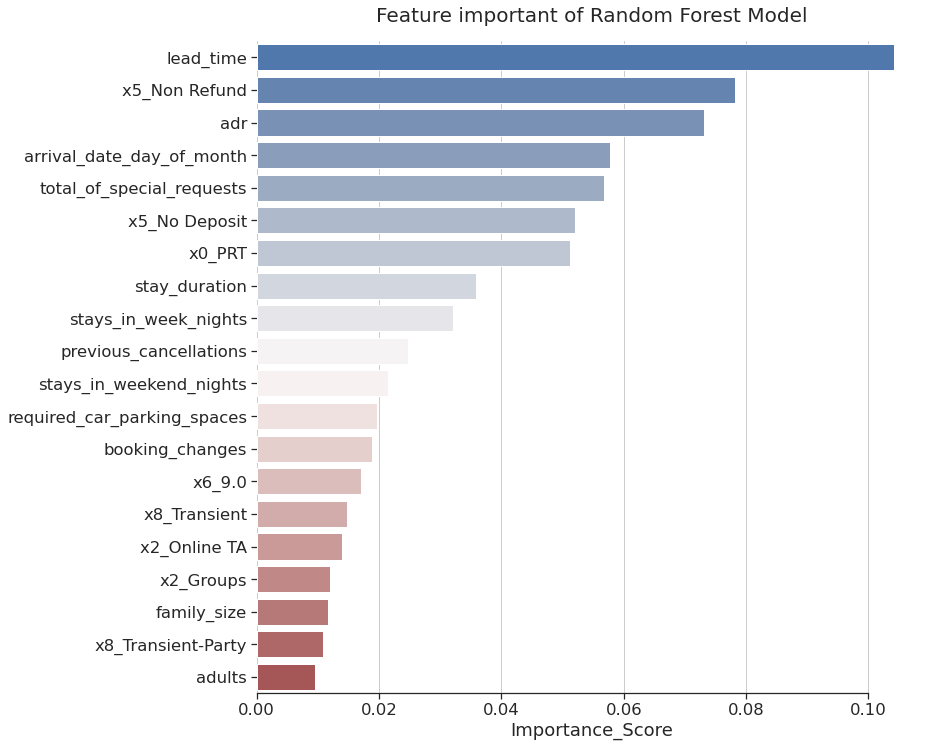

In [40]:
#Based on random forest classifier model
importance_rfc = pd.DataFrame(data=rfc_ori.feature_importances_, index = A+B+C+D,columns=['Importance_Score'])
importance_rfc.sort_values(by='Importance_Score',ascending=False)[:20]

#Plot graph
sns.set(style="ticks",font_scale = 1.5)

# Initialize the figure
f, ax = plt.subplots(figsize=(12, 12))

sns.barplot(x = 'Importance_Score', 
            y=importance_rfc.sort_values(by='Importance_Score',ascending=False).iloc[:20].index,
            data= importance_rfc.sort_values(by='Importance_Score',ascending=False).iloc[:20],
           palette="vlag")
           
ax.xaxis.grid(True)
ax.set_title('Feature important of Random Forest Model', size = 20, y = 1.02)
sns.despine(trim=True, left=True)

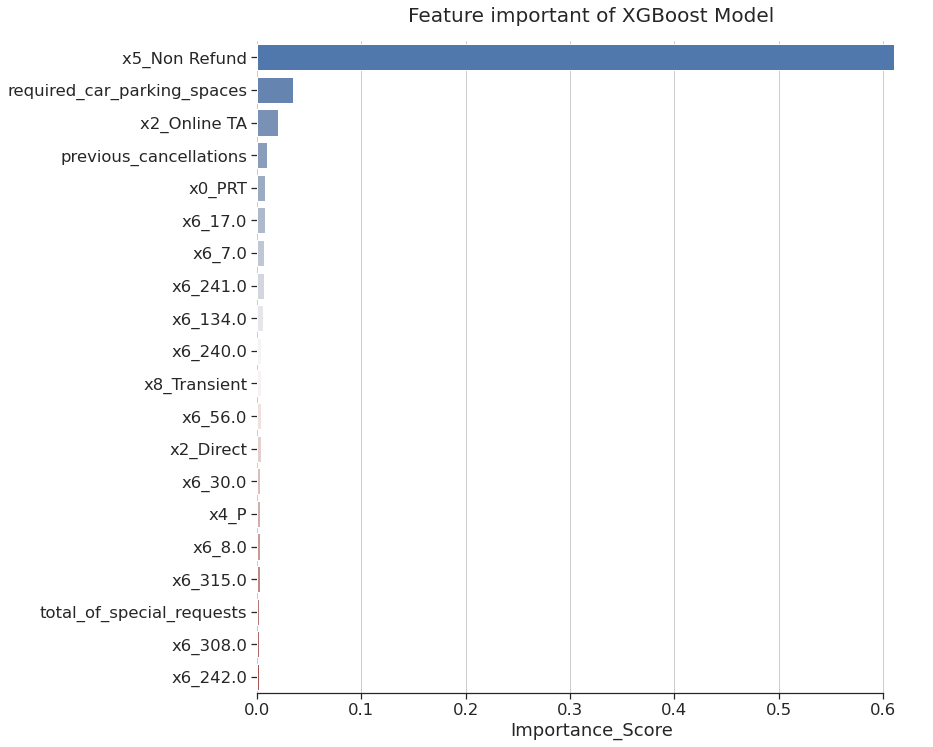

In [41]:
#Based on XGBoost model
importance_xgb = pd.DataFrame(data=xgb_tune.feature_importances_, index = A+B+C+D,columns=['Importance_Score'])
importance_xgb.sort_values(by='Importance_Score',ascending=False)[:20]

#Plot graph
sns.set(style="ticks",font_scale = 1.5)

# Initialize the figure
f, ax = plt.subplots(figsize=(12, 12))

sns.barplot(x = 'Importance_Score', 
            y=importance_xgb.sort_values(by='Importance_Score',ascending=False).iloc[:20].index,
            data= importance_xgb.sort_values(by='Importance_Score',ascending=False).iloc[:20],
           palette="vlag")
           
ax.xaxis.grid(True)
ax.set_title('Feature important of XGBoost Model', size = 20, y = 1.02)
sns.despine(trim=True, left=True)

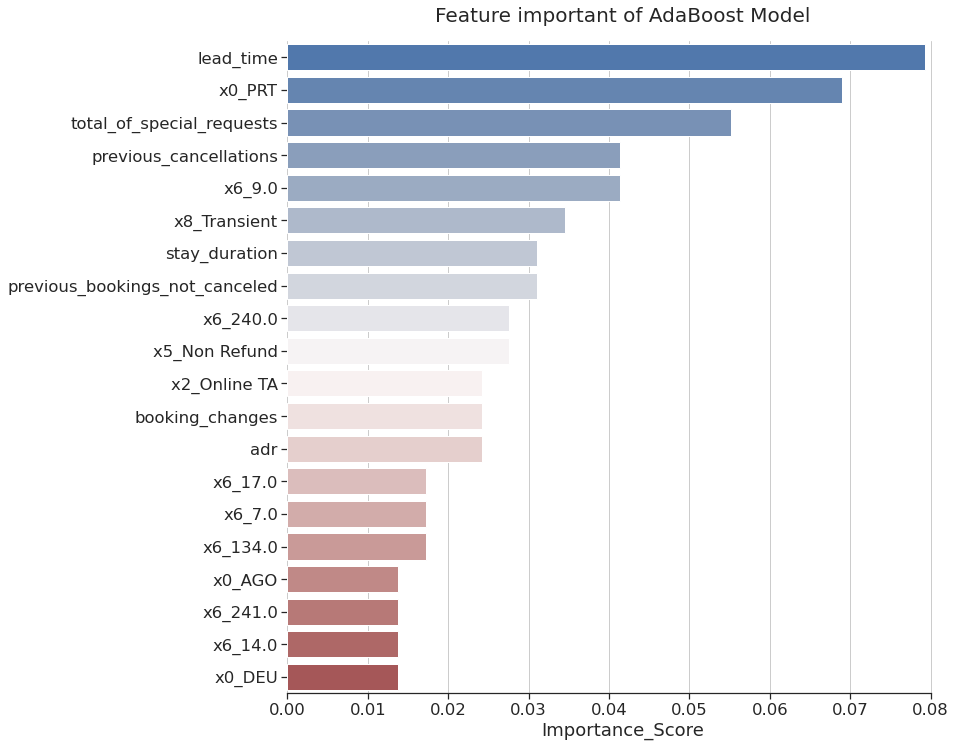

In [42]:
#Based on Adaboost model
importance_ada = pd.DataFrame(data=ada_tune.feature_importances_, index = A+B+C+D,columns=['Importance_Score'])
importance_ada.sort_values(by='Importance_Score',ascending=False)[:20]

#Plot graph
sns.set(style="ticks",font_scale = 1.5)

# Initialize the figure
f, ax = plt.subplots(figsize=(12, 12))

sns.barplot(x = 'Importance_Score', 
            y=importance_ada.sort_values(by='Importance_Score',ascending=False).iloc[:20].index,
            data= importance_ada.sort_values(by='Importance_Score',ascending=False).iloc[:20],
           palette="vlag")
           
ax.xaxis.grid(True)
ax.set_title('Feature important of AdaBoost Model', size = 20, y = 1.02)
sns.despine(trim=True, left=True)

The feature importance are shown in above figure. It’s not very surprise that lead time has most predictive power among others features. In addition, deposit requirement also have strong predictive power, since all non-refund type were almost canceled. Others importance features such as adr, countries, number of special request etc. has shown significant predictive power as we have discussed in detailed in EDA section.  Surprisingly, ‘arrival_date_day_of_month’ come up in 4th place with no clue during hand-on analysis. This could be improved if we could modify and create new features and eliminate features with low predictive power to further improve model performance.

# Conclusion

We have explored the data and able to extracted some useful insights since exploratory data analysis.  We’ve found that the booking are likely to be canceled if they have incredibly long lead time, have little or no special requirements, booked with full broad meal ,etc. Some specific group of guests also have higher chance of cancellation than the others. For example, guests from Portugal themselves has higher rate of cancellation than some foreign travelers .
<br>

Moreover, we have trained classification models to predict whether a given reservations will be canceled or not. The outcome of the model quite satisfy (with an accuracy of 89.2% ). Although it can be improved by training with more data and adjusting regularization parameters. But with current performance, our model has shown significant improvement from benchmark which can be utilized to adjust overbooking policy to achieve higher occupancy rate. In addition, even low season period when booking amount doesn’t fulfill hotel capacity. The model can be used to manage hotel workforce according to fluctuation in demand in each period of years.


Reference

1. https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md
1. data set from : https://www.sciencedirect.com/science/article/pii/S2352340918315191
1. https://www.hotelogix.com/blog/2019/08/13/why-is-overbooking-important-for-hotels-and-how-cloud-hotel-pms-helps/
1. Idea of exploratory analysis from : https://www.kaggle.com/datafan07/heart-disease-and-some-scikit-learn-magic#Inspecting-Age-Closer